# Final Project

By: Mckayla Ashley

## Sources
NASDAQ stock ticker listing: 
https://github.com/datasets/nasdaq-listings/blob/main/data/nasdaq-listed.csv

SP500 stock ticker listing:
https://gist.github.com/ZeccaLehn/f6a2613b24c393821f81c0c1d23d4192

YFinance API documentation :
https://ranaroussi.github.io/yfinance/index.html

Data Cleaning:
https://medium.com/@kiddojazz/reddit-sentiment-analysis-f8a1a790124a

In [19]:
# Import Statements
# Part 1:
import yfinance as yfin
import spacy
from spacy.matcher import PhraseMatcher
import pandas as pd
import praw
import requests
import time
from datetime import datetime, timezone

## Step 1: Gathering the Data 
### 1. Compiling list of keywords

In [20]:
# Need to compile a list of keywords and tags the scraper will search 
# through. Want to flag any stock tickers, as well as general phrases
# that indicate sentiment about the market performance. Compiling list
# of stock symbols from S&P 500 and NASDAQ data

# Source: https://github.com/datasets/nasdaq-listings/blob/main/data/nasdaq-listed.csv
nasdaq = pd.read_csv('/Users/mckaylaashley/Downloads/nasdaq-listed.csv')
nasdaq = nasdaq['Symbol'].tolist()

# Source: https://gist.github.com/ZeccaLehn/f6a2613b24c393821f81c0c1d23d4192
sp500 = pd.read_csv('/Users/mckaylaashley/Downloads/SP500.csv')
sp500 = sp500['Symbol'].tolist()

terms = ['bull', 'bear', 'crash', 'recession', 'recovery']

# Combine all terms into one
full_list = list(sp500 + nasdaq + terms)


### 2. Scraping Data, Collecting Relevant Information
#### a. Processing Raw Data
Note: Took 99 minutes to run

In [ ]:
# Gathering the data necessary to perform sentiment analysis. 
# We will be pulling from several subreddits from the year 2022, as this
# was the year Xinjie's research was conducted. 
# ----------------------------------------------------------------------
# Setting up the Python Reddit API Wrapper
reddit = praw.Reddit(
    client_id='Mz6Fd0GAiPOb7IbwKTVvgg',
    client_secret='A2TN2LmGSvdbl2AfLeJVgAXTmx8nlg',
    user_agent='my_reddit_scraper'
)

weeks_in_march = [("2022-03-01", "2022-03-07"),
                    ("2022-03-08", "2022-03-14"),
                     ("2022-03-15", "2022-03-21"),
                    ("2022-03-22", "2022-03-28")]

def in_2022(timestamp):
    post_date = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    # print(f"Timestamp: {timestamp}, Date: {post_date}")  # Debug: Check timestamp and date
    return post_date.year == 2022

weeks_in_march = [(datetime.strptime(start, "%Y-%m-%d").replace(tzinfo=timezone.utc), 
                   datetime.strptime(end, "%Y-%m-%d").replace(tzinfo=timezone.utc)) 
                   for start, end in weeks_in_march]

# time period year 2022
def get_week(timestamp):
    date_posted = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    for idx, (start, end) in enumerate(weeks_in_march):
        if start <= date_posted <= end:
            return idx  # Return the index of the matching week
    return None  # Return None if not in March weeks


comments = {stock: {week: [] for week in range(len(weeks_in_march))} for stock in full_list}

for stock in full_list:
    # for posts on the subreddit
    for submission in reddit.subreddit('stocks').search(stock, limit=1000):
        # if date posted was in 2022
        if in_2022(submission.created_utc):
            week = get_week(submission.created_utc)
            if week is not None:
                submission.comments.replace_more(limit=0)
                # check post comments, ensure posted in 2022
                for comment in submission.comments.list():
                   comment_week = get_week(comment.created_utc)
                   if comment_week is not None:
                        if isinstance(comment.body, str):
                           comment_body = ''.join([char.lower() if char.isalnum() or char.isspace() else '' for char in comment.body])
                        else:
                           comment_body = ''
                        if comment_body != '':  
                            try:
                                if any(keyword.lower() in comment_body for keyword in full_list):
                                    comments[stock][comment_week].append(comment.body)
                            except Exception as e:
                                print(f"Error processing comment: {e}")
                                print(f"Comment body: {comment.body}")
                                continue  # 
                time.sleep(1) # prevent API from overloading


Error processing comment: 'float' object has no attribute 'lower'
Comment body:  BUY
Error processing comment: 'float' object has no attribute 'lower'
Comment body: gⓂ️ē
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Bbig
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Why?
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Sens
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Zi
Error processing comment: 'float' object has no attribute 'lower'
Comment body: RUN
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Gwh
Error processing comment: 'float' object has no attribute 'lower'
Comment body: why B?
Error processing comment: 'float' object has no attribute 'lower'
Comment body: EPS -0.15
Error processing comment: 'float' object has no attribute 'lower'
Comment body: Buy
Error processing comment: 'float' object has no attribute 'lowe

In [ ]:
import csv

fieldnames = ['comment', 'week']

with open('/Users/mckaylaashley/Downloads/comments_data.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()

    for stock, weeks in comments.items():
        for week, comment_list in weeks.items():
            for comment in comment_list:
                # timestamp = comment.created_utc
                writer.writerow({'week': week, 
                                 'comment': comment, 
                                })


AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Convert to dictionary

import csv

comments_dict = []
with open('comments_data.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        comments_dict.append(row)


#### b. Cleaning Data 

In [ ]:
import re

# Remove 

full_list = [str(stock) for stock in full_list]

def cleanAndKey_comments(comment_text):
    if not isinstance(comment_text, str):
        return []
    
    # links
    comment_text = re.sub(r'http\S+|www\S+', '', comment_text)
    #  hashtags
    comment_text = re.sub(r'#\S+', '', comment_text)
    #  mentions (e.g., @username)
    comment_text = re.sub(r'@\S+', '', comment_text)
    #  non-alphanumeric characters except spaces
    comment_text = re.sub(r'[^a-zA-Z0-9\s]', '', comment_text)
    #  to lowercase
    comment_text = comment_text.lower()
    # extra whitespace
    comment_text = re.sub(r'\s+', ' ', comment_text).strip()
     
     
    matchKeywords_stocks = [stock for stock in full_list if 
                            stock.lower() in comment_text]
    return comment_text

# Original comments
comments = []

with open('comments_data.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        comments.append(row)

commentsdf = pd.DataFrame(comments)
commentsdf = commentsdf[commentsdf[
                'comment'].apply(lambda x: isinstance(x, str))]


with open('updated_comments_data.csv', mode='w', newline='', encoding='utf-8') as file:
    fieldnames = ['comment', 'week', 'stock']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in cleanKeyed_comments:
        writer.writerow(row)


Updated comments with stocks have been saved to 'updated_comments_data.csv'.


In [ ]:


for stock, weeks in comments.items():
    for week, comment_list in weeks.items():
        for comment_data in comment_list:
            cleaned_comment = clean_comment(comment_data)
            cleaned_comments.append({
                'stock': stock,
                'week': week,
                'comment': cleaned_comment,
            })

# writing cleaned comments to CSV 
with open('cleaned_comments_data.csv', mode='w', newline='', encoding='utf-8') as file:
    fieldnames = ['stock', 'week', 'comment', 'timestamp', 'upvotes', 'author']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for cleaned_comment in cleaned_comments:
        writer.writerow(cleaned_comment)


AttributeError: 'list' object has no attribute 'items'

## Step 2: Performing Sentiment Analysis 
2.1 

In [34]:
# Part 2
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch import softmax
import torch
import spacy
import pandas as pd
import re

In [37]:
# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

# Importing dataset
matched_terms_df = pd.read_csv('cleaned_comments_data.csv')
print(matched_terms_df.head())

def clean_and_lemmatize(comment_text):
    if not isinstance(comment_text, str):
        return None
    doc = nlp(comment_text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text

matched_terms_df['comment_cleaned'] = matched_terms_df['comment'].apply(clean_and_lemmatize)

# remove if a float or "removed"
df_cleaned = matched_terms_df[matched_terms_df['comment'].apply(lambda x: isinstance(x, str) and x.strip().lower() != 'deleted')]
df_cleaned.to_csv('finalfinal_dataset.csv', index=False)


  stock  week                                            comment  timestamp  \
0   MMM     1  welcome to rstocks for beginner advice brokera...        NaN   
1   MMM     1  lawsuits scare me away from them i know you me...        NaN   
2   MMM     1  be greedy when others are fearful the lawsuits...        NaN   
3   MMM     1      i just did a little trend analysis of it here        NaN   
4   MMM     1  3m is a good blue chip company dont expect to ...        NaN   

   upvotes  author  
0      NaN     NaN  
1      NaN     NaN  
2      NaN     NaN  
3      NaN     NaN  
4      NaN     NaN  


In [ ]:
import pandas as pd
import re

# Need to compile a list of keywords and tags the scraper will search 
# through. Want to flag any stock tickers, as well as general phrases
# that indicate sentiment about the market performance. Compiling list
# of stock symbols from S&P 500 and NASDAQ data

# Source: https://github.com/datasets/nasdaq-listings/blob/main/data/nasdaq-listed.csv
nasdaq = pd.read_csv('/Users/mckaylaashley/Downloads/nasdaq-listed.csv')
nasdaq = nasdaq['Symbol'].tolist()

# Source: https://gist.github.com/ZeccaLehn/f6a2613b24c393821f81c0c1d23d4192
sp500 = pd.read_csv('/Users/mckaylaashley/Downloads/SP500.csv')
sp500 = sp500['Symbol'].tolist()

terms = ['bull', 'bear', 'crash', 'recession', 'recovery']

# Combine all terms into one
full_list = list(sp500 + nasdaq + terms)
full_list = [str(keyword) for keyword in full_list if isinstance(keyword, (str, int, float))]


# Load data
df = pd.read_csv('finalfinal_dataset.csv')

# Compile the regex for matching keywords in full_list
keyword_pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in full_list) + r')\b', re.IGNORECASE)

# Function to clean and match stocks
def match_keywords(comment_text):
    # Check if the comment is a string
    if not isinstance(comment_text, str):
        return []
    
    # Match keywords in the comment
    matches = keyword_pattern.findall(comment_text)
    return list(set(matches))  # Remove duplicates

# Filter and clean comments
df['keywords'] = df['comment'].apply(match_keywords)  # Extract keywords
filtered_df = df[df['keywords'].str.len() > 0]  # Filter rows with at least one match

# Save the filtered DataFrame to a new CSV (optional)
filtered_df.to_csv('finfiltered_comments.csv', index=False)

# Preview the filtered DataFrame
print(filtered_df.head())

KeyboardInterrupt: 

In [ ]:
import pandas as pd

alguindy = pd.read_csv('/Users/mckaylaashley/Downloads/Top200_2022.csv')
print(alguindy.head())

In [ ]:
nonspec_tickers = {
    'TSLA': 'Tesla',
    'AAPL': 'Apple',
    'AMZN': 'Amazon',
    'META': 'Meta',
    'MSFT': 'Microsoft',
    'AMC': 'AMC Entertainment',
    'GOOGL': 'Google',
    'NVDA': 'NVIDIA',
    'NFLX': 'Netflix',
    'GME': 'GameStop',
    'TWTR': 'Twitter',
    'AAL': 'American Airlines',
    'ROKU': 'Roku',
    'PYPL': 'PayPal Holdings, ',
    'SNAP': 'Snap Inc',
    'DAL': 'Delta Air',
    'SQ': 'Block',
    'JPM': 'JPMorgan Chase',
    'DKNG': 'DraftKings',
    'MRNA': 'Moderna',
    'INTC': 'Intel Corp',
    'PENN': 'Penn National Gaming',
    'NKLA': 'Nikola',
    'WMT': 'Walmart',
    'LCID': 'Lucid Group',
    'HD': 'Home Depot',
    'XOM': 'Exxon',
    'INO': 'Inovio',
    'BBIG': 'Vinco Ventures',
    'CRM': 'Salesforce',
    'PLTR': 'Palantir',
    'PTON': 'Peloton',
    'GS': 'Goldman',
    'OXY': 'Occidental Petroleum',
    'GM': 'General Motors',
    'DWAC': 'Digital World Acquisition',
    'ADBE': 'Adobe',
    'BYND': 'Beyond Meat',
    'JNJ': 'Johnson & Johnson',
    'PFE': 'Pfizer',
    'MULN': 'Mullen',
    'KO': 'Coca-Cola',
    'GNUS': 'Genius Brands',
    'WFC': 'Wells Fargo',
    'ZM': 'Zoom',
    'SOFI': 'SoFi',
    'NKE': 'Nike',
    'LUV': 'Southwest',
    'TLRY': 'Tilray',
    'SPCE': 'Virgin Galactic',
    'MGM': 'MGM Resorts',
    'COST': 'Costco',
    'UBER': 'Uber'
}

In [ ]:
# Mapping of specific tickers to company names
spec_tickers = {
    'T': 'AT&T.',
    'MA': 'Mastercard',
    'ES': 'Eversource Energy',
    'M': 'Macy',
    'W': 'Wayfair.',
    'NET': 'Cloudflare.',
    'EA': 'Electronic Arts',
    'U': 'Unity Software',
    'X': 'United States Steel',
    'ON': 'ON Semiconductor',
    'MO': 'Altria ',
    'A': 'Agilent Technologies',
    'BA': 'Boeing',
    'F': 'Ford Motor',
    'DIS': 'Disney',
    'BAC': 'Bank of America',
    'V': 'Visa',
     'UAL': 'United Airlines',
    'PLUG': 'Plug Power',
    'AMD': 'Advanced Micro Devices'
}

In [ ]:
import pandas as pd
import re

df = pd.read_csv('finfiltered_comments.csv')

all_tickers = {**spec_tickers, **nonspec_tickers}

def match_keywords(comment_text):
    if not isinstance(comment_text, str):
        return []

    matched_tickers = []

    # look for company name
    for ticker, company in spec_tickers.items():
        if company.lower() in comment_text.lower():
            matched_tickers.append(ticker)

    # look for ticker and company name
    for ticker, company in nonspec_tickers.items():
        if ticker.lower() in comment_text.lower() or company.lower() in comment_text.lower():
            matched_tickers.append(ticker)

    # remove duplicates
    return list(set(matched_tickers))


df['matched_tickers'] = df['comment'].apply(match_keywords)

filtered_df = df[df['matched_tickers'].str.len() > 0]

filtered_df.to_csv('filtered_by_alguindy_tickers.csv', index=False)
print(filtered_df[['comment', 'matched_tickers']].head())

filfilter_df = filtered_df

finfilter_df = filtered_df.drop(columns=['stock', 'timestamp', 'upvotes', 'author'])
finfilter_df.to_csv('finfiltered_by_alguindy_tickers.csv', index=False)


NameError: name 'spec_tickers' is not defined

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import softmax
from textblob import TextBlob
import torch
import pandas as pd

results = []


# hugging face 
pipe = pipeline("text-classification", model="ProsusAI/finbert")    
tokenizer = tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
analyzer = SentimentIntensityAnalyzer()

# VADER
def categories(compound_score):
    if compound_score > 0.65:
        return "Very Positive"
    elif 0.2 < compound_score <= 0.65:
        return "Slightly Positive"
    elif -0.2 <= compound_score <= 0.2:
        return "Neutral"
    elif -0.65 <= compound_score < -0.2:
        return "Slightly Negative"
    else:
        return "Very Negative"

# textblob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df_cleaned['subjectivity'] = df_cleaned['comment'].apply(
    getSubjectivity)
df_cleaned['polarity'] = df_cleaned['comment'].apply(
    getPolarity)
df_cleaned.head()

# Testing

for comment in comments:
    vader = analyzer.polarity_scores(comment)['compound']
    vader_category = categories(vader)

    inputs = tokenizer(comment, return_tensors = "pt", truncation=True, 
                       padding=True, max_length = 512)
    outputs = model(**inputs)
    logits=outputs.logits
    probs=softmax(logits, dim=1)
    finbert = ["negative", "neutral", "positive"][torch.argmax(probs).item()]

    results.append({
        "comment":comment,
        "vader_score":vader,
        "vader_category":vader_category,
        "finbert_sentiment":finbert})
    
for res in results:
    print(f"Comment: {res['comment']}")
    print(f"VADER Score: {res['vader_score']}")
    print(f"VADER Category: {res['vader_category']}")
    print(f"finbert Sentiment: {res['finbert_sentiment']}")
    print()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/rj/_c2qxh155cx0zbl6n49s95kr0000gn/T/ipykernel_6599/1698847103.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Comment: I think Apple's stock will go up after the new iPhone launch!
  VADER Score: 0.0
  VADER Category: Neutral
  FinBERT Sentiment: negative

Comment: Tesla stock has been dropping recently, I'm worried.
  VADER Score: -0.296
  VADER Category: Slightly Negative
  FinBERT Sentiment: neutral

Comment: Amazon's new initiatives seem promising.
  VADER Score: 0.4019
  VADER Category: Slightly Positive
  FinBERT Sentiment: negative



In [ ]:
matched_terms_df["Insight"] = matched_terms_df["Polarity"].apply(categories)
matched_terms_df.head(50)

,week,comment,matched_terms,Subjectivity,Polarity,Insight
0,1,welcome to rstocks for beginner advice brokera...,NaN,0.457967,0.249176,Slightly Positive
1,1,lawsuits scare me away from them i know you me...,NaN,0.393750,0.116146,Neutral
2,1,be greedy when others are fearful the lawsuits...,NaN,0.875000,-0.050000,Neutral
3,1,i just did a little trend analysis of it here,NaN,0.500000,-0.187500,Neutral
4,1,3m is a good blue chip company dont expect to ...,NaN,0.507143,0.339286,Slightly Positive
5,1,good stock good business reasonably priced gre...,NaN,0.690000,0.540000,Slightly Positive
6,1,this is one of those times you should be fearf...,NaN,0.590000,0.050000,Neutral
7,1,over a quarter of million lawsuits and growing...,NaN,0.400000,-0.150000,Neutral
8,1,the lawsuits mainly i went with dow and its a ...,NaN,0.677778,0.388889,Slightly Positive
9,1,does the decreased mask sales lower the revenu...,NaN,0.450000,-0.100000,Neutral


In [ ]:
doc = nlp(sample_comment)
matches = phrase_matcher(doc)

for match_id, start, end in matches:
    span = doc[start:end]
    print(f"Matched: {span.text} (Start: {start}, End: {end})")


# Cleaned and keyed comments
cleanKeyed_comments = []

for row in comments:
    comment_text = row['comment']
    week = row['week']

    keyed_stocks = cleanAndKey_comments(comment_text)
    stocks = ', '.join(keyed_stocks) if keyed_stocks else "No Match"
    
    cleanKeyed_comments.append({ 
        'comment': comment_text,
        'week': week,
        'stock': stocks
    })



In [ ]:
finfilter_df.to_csv('other.csv')


In [1]:

def analyze_sentiment(comments):
    results = []
    
    for comment in comments:
        # VADER 
        vader = analyzer.polarity_scores(comment)['compound']
        vader_category = categories(vader)
        
        # FinBERT 
        inputs = tokenizer(comment, return_tensors="pt", truncation=True, 
                           padding=True, max_length=512)
        outputs = model(**inputs)
        logits = outputs.logits
        probs = softmax(logits, dim=1)
        finbert = ["negative", "neutral", "positive"][torch.argmax(probs).item()]
        
        # Store 
        results.append({
            "comment": comment,
            "vader_score": vader,
            "vader_category": vader_category,
            "finbert_sentiment": finbert
        })
    
    return results

In [64]:
finfilter_df = pd.read_csv('final_data.csv')


comments = [
    "i absolutely love adbe right now 5k is a pretty hefty loss to just" + 
        "take though tough call,I absolutely love adbe right now 5k be" + 
         "a pretty hefty loss to just take though tough call",
    "lost 48k on sofi",
    "lol yeah tech is rewarding but risky ive got plans to add ddog msft" + 
     "and voo theyll be my tech sector along with rblx i try to play it safe with tech."
]

sentiment_results = analyze_sentiment(comments)


for res in sentiment_results:
    print(f"Comment: {res['comment']}")
    print(f"  VADER Score: {res['vader_score']}")
    print(f"  VADER Category: {res['vader_category']}")
    print(f"  FinBERT Sentiment: {res['finbert_sentiment']}")

    print()

print("Textblob sentiment: neutral")
print("Textblob sentiment: neutral")
print("Textblob sentiment: Slightly Positive")



Comment: i absolutely love adbe right now 5k is a pretty hefty loss to justtake though tough call,I absolutely love adbe right now 5k bea pretty hefty loss to just take though tough call
  VADER Score: 0.8953
  VADER Category: Very Positive
  FinBERT Sentiment: positive

Comment: lost 48k on sofi
  VADER Score: -0.3182
  VADER Category: Slightly Negative
  FinBERT Sentiment: neutral

Comment: lol yeah tech is rewarding but risky ive got plans to add ddog msftand voo theyll be my tech sector along with rblx i try to play it safe with tech.
  VADER Score: 0.8573
  VADER Category: Very Positive
  FinBERT Sentiment: positive

Textblob sentiment: neutral
Textblob sentiment: neutral
Textblob sentiment: Slightly Positive


## Cleaning using STOPWORDS 

In [79]:
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

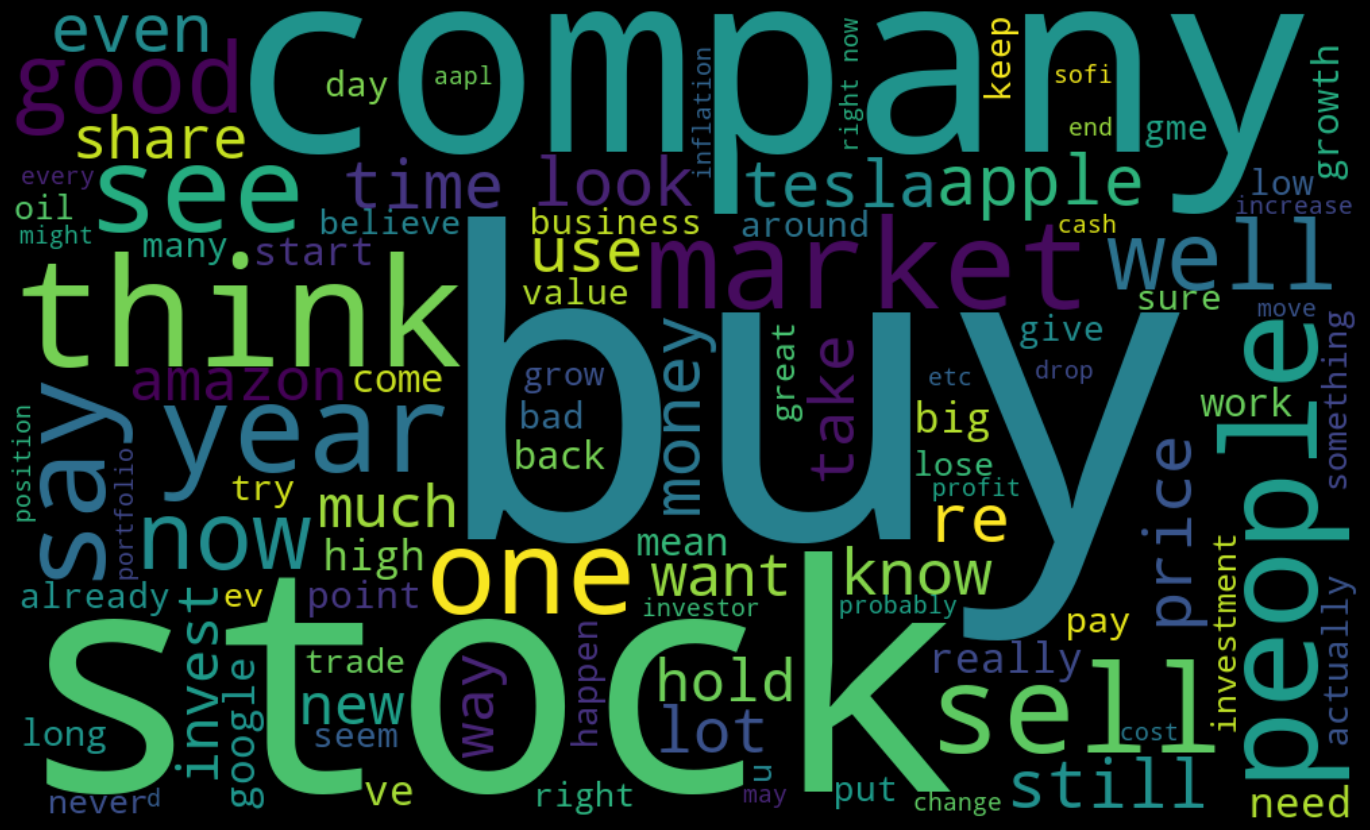

In [81]:
stopwords = STOPWORDS

custom_stopwords = ['thing', 'make', 'will', 'go', 'm', 's', ]
stopwords.update(custom_stopwords)

final_data = pd.read_csv('final_data.csv')


text = ''.join([twts for twts in final_data['comment_cleaned']] ) #To join all tweet
 # generate word cloud 
wordcloud = WordCloud(width=1000, height = 600, 
 max_words = 100,
 stopwords = stopwords,
 background_color="black").generate(text)
# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import torch
from torch.nn.functional import softmax
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import softmax
from textblob import TextBlob


df_comments = pd.read_csv('textblob_filtering_small.csv')
df_comments = df_comments.drop(['Subjectivity', 'Polarity'], axis=1)
df_comments.to_csv('modelanalysis.csv')

def analyze_sentiment_vader(comment):
    if isinstance(comment, str):
        return analyzer.polarity_scores(comment)['compound']  # Get compound score

# use VADER 
df_comments['vader_score'] = df_comments['comment'].apply(analyze_sentiment_vader)

# Ccategorize
def categorize_sentiment(compound_score):
    if compound_score > 0.7:
        return "Very Positive"
    elif 0.2 < compound_score <= 0.7:
        return "Slightly Positive"
    elif -0.2 <= compound_score <= 0.2:
        return "Neutral"
    elif -0.7 <= compound_score < -0.2:
        return "Slightly Negative"
    else:
        return "Very Negative"


df_comments['vader_sentiment'] = df_comments['vader_score'].apply(categorize_sentiment)



In [109]:
df_comments.to_csv('modelanalysis.csv')

## Sampling 30 Random Comments for Manual Classsification


In [113]:
sample_comments = df_comments['comment'].sample(30, random_state=42)

for idx, comment in enumerate(sample_comments, 1):
    print(f"{idx}. {comment}")

1. just wait till you google love canal outside buffaloniagara falls
2. you still believe in dis and pypl
3. calls on nike
4. short squeeze algos push this to extremes a lot of the less liquid commodities have this issue some assclowns always get stuck short and blow out
5. i had to google who that even is i just want the specifics on democrat hawkery as im quite familiar with us hawkery
6. is there another stock subreddit that doesnt have just emotional daytrader gamblers im so irritated in these subs its like a bunch of lamen folks googling web md for their diagnoses
7. google starbucks quarterly report thats where u get assets and liabilities then you can compute roe and roa
8. pltr sofi bldp
9. lol an nkla investor talking smack
10. a vocal minority enter the conversation in bad faith since they believe in conspiracy theories and attack any criticism as the work of shills its not worth to try to have the conversation on social media
11. maybe a little guidance from coach tuberville

In [ ]:
def categorize_sentiment(polarity):
    if polarity > 0.7:
        return "Very Positive"
    elif 0.2 < polarity <= 0.7:
        return "Slightly Positive"
    elif -0.2 <= polarity <= 0.2:
        return "Neutral"
    elif -0.7 <= polarity < -0.2:
        return "Slightly Negative"
    else:
        return "Very Negative"

# TextBlob - Subjectivity and Polarity Functions

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

manual_labels = ['Neutral', 'Slightly Negative', 'neutral', 'negative', 'slightly negative', 
                 'negative', 'neutral', 'neutral', 'slightly negative', 'slightly negative', 
                 'neutral', 'positive', 'neutral', 'slightly positive', 'negative', 'slightly negative', 
                 'negative', 'negative', 'negative', 'negative', 'slightly positive', 'positive', 
                 'slightly posiitve', 'neutral', 'slightly negative', 'negative', 'neutral', 'positive', 
                 'positive', 'slightly positive']

sample_comments_df = pd.DataFrame({
    'comment': sample_comments,
    'manual_label': manual_labels
})

analyzer = SentimentIntensityAnalyzer()

def analyze_timent_vader(comment):
    score = analyzer.polarity_scores(comment)['compound']
    return categorize_sentiment(score)
  
def map_to_general_sentiment(label):
    if 'positive' in label.lower():
        return 'positive'
    elif 'negative' in label.lower():
        return 'negative'
    else:
        return 'neutral'


    
sample_comments_df['vader_pred'] = sample_comments_df['comment'].apply(analyze_timent_vader)
sample_comments_df['textblob_pred'] = sample_comments_df['comment'].apply(lambda x: categorize_sentiment(getPolarity(x)))

sample_comments_df['manual_label_general'] = sample_comments_df['manual_label'].apply(map_to_general_sentiment)
sample_comments_df['vader_pred_general'] = sample_comments_df['vader_pred'].apply(map_to_general_sentiment)
sample_comments_df['textblob_pred_general'] = sample_comments_df['textblob_pred'].apply(map_to_general_sentiment)

vader_correct = (sample_comments_df['vader_pred_general'].str.lower() == sample_comments_df['manual_label'].str.lower()).sum()
vader_total = len(sample_comments_df)
vader_accuracy = vader_correct / vader_total
print(f"VADER Accuracy: {vader_accuracy * 100:.2f}%")

textblob_correct = (sample_comments_df['textblob_pred_general'].str.lower() == sample_comments_df['manual_label'].str.lower()).sum()
textblob_total = len(sample_comments_df)
textblob_accuracy = textblob_correct / textblob_total
print(f"TextBlob Accuracy: {textblob_accuracy * 100:.2f}%")

sample_comments_df.to_csv('comparison.csv')

VADER Accuracy: 40.00%
TextBlob Accuracy: 30.00%


In [ ]:
df_modelanalysis = pd.read_csv("modelanalysis.csv")
df_nasdaq_listed = pd.read_csv("/Users/mckaylaashley/Downloads/Top200_2022.csv")
df_modelanalysis['matched_tickers'] = df_modelanalysis['matched_tickers'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_modelanalysis['matched_tickers'] = df_modelanalysis['matched_tickers'].apply(
    lambda x: [str(ticker).strip().upper() for ticker in x] if isinstance(x, list) else [str(x).strip().upper()]
)


df_nasdaq_listed['Ticker'] = df_nasdaq_listed['Ticker'].apply(lambda x: str(x).strip().upper())

ticker_to_industry = dict(zip(df_nasdaq_listed['Ticker'], df_nasdaq_listed['Industry']))

def get_industries(tickers):
    industries = []
    
    for ticker in tickers:
        if ticker in ticker_to_industry:
            industries.append(ticker_to_industry[ticker])
        else:
            industries.append('not known')  
            
    return ', '.join(industries)  

df_modelanalysis['industries'] = df_modelanalysis['matched_tickers'].apply(get_industries)

df_modelanalysis.to_csv("final_modelanalysis_with_industry.csv")

Sample of matched_tickers in modelanalysis (after cleaning):
0                  [MSFT]
1                   [JNJ]
2    [WFC, SOFI, V, AAPL]
3                   [DAL]
4                    [MO]
Name: matched_tickers, dtype: object
Sample of tickers in nasdaq-listed (after cleaning):
0    TSLA
1    AAPL
2    AMZN
3    META
4    MSFT
Name: Ticker, dtype: object
Sample of updated DataFrame with industries:
        matched_tickers                industries
0                [MSFT]                     BusSv
1                 [JNJ]                     MedEq
2  [WFC, SOFI, V, AAPL]  Banks, Fin, BusSv, Comps
3                 [DAL]                     Trans
4                  [MO]                     Smoke


In [ ]:
import pandas as pd

df = pd.read_csv("final_modelanalysis_with_industry.csv")

df_cleaned = df[['week', 'comment', 'comment_cleaned', 'matched_tickers', 'vader_score', 'vader_sentiment', 'industries']]
df_cleaned.to_csv("donedone.csv", index=False)


In [93]:

df_comments_encoded = pd.get_dummies(df_cleaned, columns=['industries'], drop_first=True)
print(df_comments_encoded)


TypeError: unhashable type: 'list'

In [ ]:
# get industries

split_industries = df_cleaned['industries'].str.split(',').explode()
split_industries = split_industries.str.strip().str.lower()
unique_industries = split_industries.unique()

print(f"we have  {len(unique_industries)} different industries.")
print(unique_industries)


There are 21 different industries.
Industries:
['bussv' 'medeq' 'banks' 'fin' 'comps' 'trans' 'smoke' 'unclassified'
 'soda' 'chips' 'telcm' 'rtail' 'fun' 'autos' 'labeq' 'clths' 'elceq'
 'oil' 'aero' 'drugs' 'meals']


In [ ]:
import pandas as pd
import ast

df_cleaned.loc[:, 'matched_tickers'] = df_cleaned['matched_tickers'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df_cleaned = df_cleaned.explode('matched_tickers')

# reset index
df_cleaned.reset_index(drop=True, inplace=True)



0       MSFT
1        JNJ
2        WFC
3       SOFI
4          V
        ... 
8389    MRNA
8390    AAPL
8391     WMT
8392     XOM
8393     JNJ
Name: matched_tickers, Length: 8394, dtype: object


In [ ]:
import pandas as pd

df_cleaned.to_csv('fixed.csv')

df_cleaned['matched_tickers'] = df_cleaned['matched_tickers'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_cleaned['industries'] = df_cleaned['industries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = df_cleaned.explode(['matched_tickers', 'industries'])


df_encoded = pd.get_dummies(df_exploded['industries'], prefix='industry')

df_exploded = df_exploded[['matched_tickers']]  
df_encoded = pd.concat([df_exploded, df_encoded], axis=1) 
df_encoded = df_encoded.drop_duplicates(subset='matched_tickers', keep='first') 

df_encoded.to_csv('industries_encoded.csv', index=False)



  matched_tickers  industry_Aero  industry_Autos  industry_Banks  \
0            MSFT          False           False           False   
1             JNJ          False           False           False   
2             WFC          False           False            True   
2            SOFI          False           False           False   
2               V          False           False           False   

   industry_BusSv  industry_Chips  industry_Clths  industry_Comps  \
0            True           False           False           False   
1           False           False           False           False   
2           False           False           False           False   
2           False           False           False           False   
2            True           False           False           False   

   industry_Drugs  industry_ElcEq  ...  industry_LabEq  industry_Meals  \
0           False           False  ...           False           False   
1           False           

/var/folders/rj/_c2qxh155cx0zbl6n49s95kr0000gn/T/ipykernel_19647/3834006748.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['matched_tickers'] = df_cleaned['matched_tickers'].apply(
/var/folders/rj/_c2qxh155cx0zbl6n49s95kr0000gn/T/ipykernel_19647/3834006748.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['industries'] = df_cleaned['industries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
import pandas as pd
import ast

weekly_sentiment = pd.read_csv('weekly_sentiment.csv')

weekly_sentiment['matched_tickers'] = weekly_sentiment['matched_tickers'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

weekly_sentiment = weekly_sentiment.explode('matched_tickers')

weekly_sentiment.reset_index(drop=True, inplace=True)

df_avg_vader = weekly_sentiment.groupby(['matched_tickers', 'week'], as_index=False)['vader_score'].mean()

df_merged = pd.merge(weekly_sentiment, df_avg_vader, on=['matched_tickers', 'week'], how='left', suffixes=('', '_avg'))

df_merged.to_csv('vader_avg.csv')

  matched_tickers  week  vader_score  vader_score_avg
0             AAL     0    -0.082750         0.173462
1             AAL     2    -0.924300        -0.924300
2            AAPL     0     0.152677         0.299761
3            AAPL     1     0.215707         0.203213
4            AAPL     2     0.217589         0.413171


In [ ]:
import yfinance as yf
import re
import ast

weeks_in_march = [
    ("2022-03-01", "2022-03-07"),
    ("2022-03-08", "2022-03-14"),
    ("2022-03-15", "2022-03-21"),
    ("2022-03-22", "2022-03-28")
]

# Week labels (0-3)
week_labels = [0, 1, 2, 3]

df_cleaned.loc[:, 'matched_tickers'] = df_cleaned['matched_tickers'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
tickers = df_cleaned['matched_tickers'].explode().unique()


['MSFT' 'JNJ' 'WFC' 'SOFI' 'V' 'AAPL' 'DAL' 'MO' 'JPM' 'TLRY' 'KO' 'AMZN'
 'GOOGL' 'INTC' 'PLTR' 'LUV' 'BAC' 'DIS' 'META' 'WMT' 'TSLA' 'SQ' 'NFLX'
 'ROKU' 'NVDA' 'PYPL' 'ADBE' 'SPCE' 'GM' 'PENN' 'LCID' 'CRM' 'SNAP' 'MRNA'
 'BYND' 'DKNG' 'PTON' 'GS' 'NKLA' 'ZM' 'INO' 'NKE' 'PLUG' 'MULN' 'GME'
 'AMC' 'MA' 'UBER' 'XOM' 'BA' 'TWTR' 'PFE' 'OXY' 'COST' 'MGM' 'AAL' 'M'
 'HD' 'BBIG' 'F' 'ON' 'GNUS']


In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame() 


weekly_stock_change = []

for ticker in tickers:
    if isinstance(ticker, list):
        ticker = ticker[0]
    
    for week, (start_date, end_date) in zip(week_labels, weeks_in_march):
        stock_data = get_stock_data(ticker, start_date, end_date)
        
        if not stock_data.empty and 'Close' in stock_data.columns:
            start_price = stock_data['Close'].iloc[0]  # First price
            end_price = stock_data['Close'].iloc[-1]  # Last price 
            price_change = ((end_price - start_price) / start_price) * 100  # Percent change
            
            weekly_stock_change.append({
                'Ticker': ticker,
                'Week': week,
                'Price Change (%)': price_change
            })
        else:
            print(f"No data for {ticker} during {start_date} to {end_date}")

# Convert to DataFrame
weekly_changes_df = pd.DataFrame(weekly_stock_change)

# Display the results
print(weekly_changes_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

KeyboardInterrupt: 

In [49]:
weekly_changes_df.to_csv('compiled_finance_data.csv')

In [ ]:
import re

weekly_changes_df = pd.read_csv('compiled_finance_data.csv')

weekly_changes_df['Price Change (%)'] = weekly_changes_df['Price Change (%)'].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)

weekly_changes_df = weekly_changes_df[['Ticker', 'Week', 'Price Change (%)']]

weekly_changes_df.to_csv('compiled_finance_data2.csv', index=False)


  Ticker  Week  Price Change (%)
0   MSFT     2          4.624760
1   MSFT     3         -0.124977
2    JNJ     0          3.341461
3    JNJ     1          0.373403
4    JNJ     2         -0.738051


# Merging

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df_encoded = pd.read_csv('industries_encoded.csv')

df_merged = pd.merge(weekly_sentiment, weekly_changes, on=['stock_ticker', 'week'], how='left')

df_cleaned['matched_tickers'] = df_cleaned['matched_tickers'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_cleaned_exploded['matched_tickers'] = df_cleaned_exploded['matched_tickers'].astype(str)
df_merged['Ticker'] = df_merged['Ticker'].astype(str)

df_final = pd.merge(df_merged, df_cleaned_exploded[['matched_tickers', 'week', 'vader_score']], 
                    left_on=['Ticker', 'Week'], 
                    right_on=['matched_tickers', 'week'], 
                    how='left')

print(df_final.head())

TypeError: Can only merge Series or DataFrame objects, a <class 'list'> was passed

In [ ]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load your data
df_merged = pd.read_csv('merged_data.csv')

df_merged['Price Change Label'] = (df_merged['Price Change (%)'] > 0).astype(int)

df_merged['industries'] = df_merged['industries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df_merged = df_merged.explode('industries')

df_features = pd.get_dummies(df_merged[['industries', 'vader_score']], columns=['industries'], drop_first=True)

X = df_features  
y = df_merged['Price Change Label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("classification report:")
print(classification_report(y_test, y_pred))

print("accuracy:")
print(accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

industries_encoded = pd.read_csv('industries_encoded.csv') 
vader_avg = pd.read_csv('vader_avg.csv') #

weekly_changes = pd.read_csv('compiled_finance_data2.csv') # prices
vader_avg = vader_avg[['matched_tickers', 'week', 'vader_score_avg']]



vader_avg['matched_tickers'] = vader_avg['matched_tickers'].astype(str)

weekly_changes['Ticker'] = weekly_changes['Ticker'].astype(str)

df_merged = pd.merge(vader_avg, weekly_changes, 
                     left_on=['matched_tickers','week']
, right_on=['Ticker', 'Week'], how='left')



0     AAL
1     AAL
2    AAPL
3    AAPL
4    AAPL
Name: matched_tickers, dtype: object
matched_tickers
<class 'str'>    2736
Name: count, dtype: int64
0    MSFT
1    MSFT
2     JNJ
3     JNJ
4     JNJ
Name: Ticker, dtype: object
Ticker
<class 'str'>    230
Name: count, dtype: int64
  matched_tickers  week  vader_score_avg
0             AAL     0         0.173462
1             AAL     2        -0.924300
2            AAPL     0         0.299761
3            AAPL     1         0.203213
4            AAPL     2         0.413171


In [ ]:
df_merged = df_merged[['matched_tickers', 'week', 'vader_score_avg']]
df_merged.to_csv('df_merged.csv')

industries_encoded = pd.read_csv('industries_encoded.csv') 

df_merged = pd.merge(
    df_merged, 
    industries_encoded, 
    on='matched_tickers', 
    how='left'
)


  matched_tickers  week  vader_score_avg
0             AAL     0         0.173462
1             AAL     2        -0.924300
2            AAPL     0         0.299761
3            AAPL     1         0.203213
4            AAPL     2         0.413171
  matched_tickers  week  vader_score_avg  industry_Aero  industry_Autos  \
0             AAL     0         0.173462          False           False   
1             AAL     2        -0.924300          False           False   
2            AAPL     0         0.299761          False           False   
3            AAPL     1         0.203213          False           False   
4            AAPL     2         0.413171          False           False   

   industry_Banks  industry_BusSv  industry_Chips  industry_Clths  \
0           False           False           False           False   
1           False           False           False           False   
2           False           False           False           False   
3           False          

In [197]:
weekly_changes = pd.read_csv('compiled_finance_data2.csv') # prices

df_merged = pd.merge(
    df_merged,
    weekly_changes,
    left_on=['matched_tickers', 'week'],
    right_on=['Ticker', 'Week'],
    how='left'
)




In [ ]:

df_merged.to_csv('merge2.csv')


df_merged['weekly_price_change'] = df_merged['weekly_price_change'].fillna(0)

def label_price_change(row):
    """
    Function to label the price change as 1 (increase) or 0 (decrease) based on the weekly price movement.
    """
    if row['weekly_price_change'] > 0:  
        return 1 
    else:
        return 0  
    
df_merged['Price_Change_Label'] = df_merged.apply(label_price_change, axis=1)
df_merged.to_csv('merge2.csv')
print(df_merged)


      Unnamed: 0 matched_tickers  week  vader_score_avg  industry_Aero  \
0              0             AAL     0         0.173462          False   
1              1             AAL     2        -0.924300          False   
2              2            AAPL     0         0.299761          False   
3              3            AAPL     1         0.203213          False   
4              4            AAPL     2         0.413171          False   
...          ...             ...   ...              ...            ...   
2731        2731               V     2         0.296200          False   
2732        2732              ZM     0         0.203393          False   
2733        2733              ZM     1         0.318399          False   
2734        2734              ZM     2         0.161621          False   
2735        2735              ZM     3         0.283907          False   

      industry_Autos  industry_Banks  industry_BusSv  industry_Chips  \
0              False           False   

In [ ]:
df_merged2 = pd.read_csv('merge2.csv')
df_merged2 = df_merged.dropna(subset=['weekly_price_change'])

df_merged['weekly_price_change'] = pd.to_numeric(df_merged['weekly_price_change'], errors='coerce')
df_merged_cleaned = df_merged.dropna(subset=['weekly_price_change'])
df_merged_cleaned.to_csv('merged3.csv')

df_merged_cleaned = df_merged_cleaned[['matched_tickers','week','vader_score_avg','industry_Aero','industry_Autos','industry_Banks',
                                       'industry_BusSv','industry_Chips','industry_Clths','industry_Comps','industry_Drugs',
                                       'industry_ElcEq','industry_Fin','industry_Fun', 'industry_LabEq','industry_Meals','industry_MedEq',
                                       'industry_Oil','industry_Rtail','industry_Smoke','industry_Soda','industry_Telcm','industry_Trans',
                                       'industry_Unclassified','weekly_price_change','Price_Change_Label']]

In [247]:
df_merged_cleaned.to_csv('merged3.csv')

# Comparison of VADER Sentiment by Price Change Label

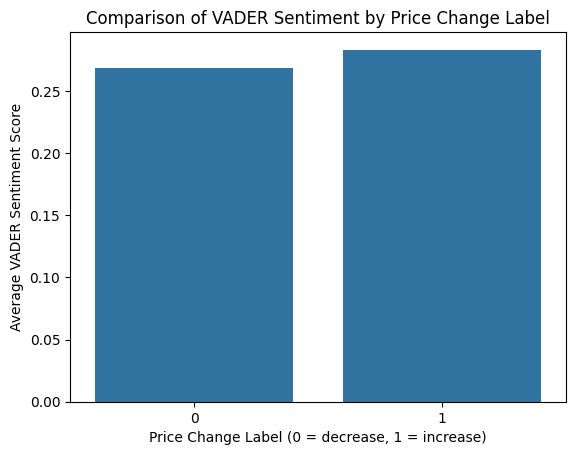

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

vader_by_label = df_merged.groupby('Price_Change_Label')['vader_score_avg'].mean()

sns.barplot(x=vader_by_label.index, y=vader_by_label.values)
plt.xlabel('Price Change Label (0 = decrease, 1 = increase)')
plt.ylabel('Average VADER Sentiment Score')
plt.title('Comparison of VADER Sentiment by Price Change Label')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

industry_columns = [col for col in df_merged_cleaned.columns if col.startswith('industry_')]
features = ['week', 'vader_score_avg'] + industry_columns
target = 'Price_Change_Label'

df_merged_cleaned = df_merged_cleaned.dropna(subset=features + [target])

X_log = df_merged_cleaned[features]
y_log = df_merged_cleaned[target]

X_log = X_log.reset_index(drop=True)
y_log = y_log.reset_index(drop=True)


(2736, 23)
(2736,)
['week', 'vader_score_avg', 'industry_Aero', 'industry_Autos', 'industry_Banks', 'industry_BusSv', 'industry_Chips', 'industry_Clths', 'industry_Comps', 'industry_Drugs', 'industry_ElcEq', 'industry_Fin', 'industry_Fun', 'industry_LabEq', 'industry_Meals', 'industry_MedEq', 'industry_Oil', 'industry_Rtail', 'industry_Smoke', 'industry_Soda', 'industry_Telcm', 'industry_Trans', 'industry_Unclassified']


              precision    recall  f1-score   support

           0       0.73      0.69      0.71       196
           1       0.70      0.73      0.71       188

    accuracy                           0.71       384
   macro avg       0.71      0.71      0.71       384
weighted avg       0.71      0.71      0.71       384

[[136  60]
 [ 51 137]]


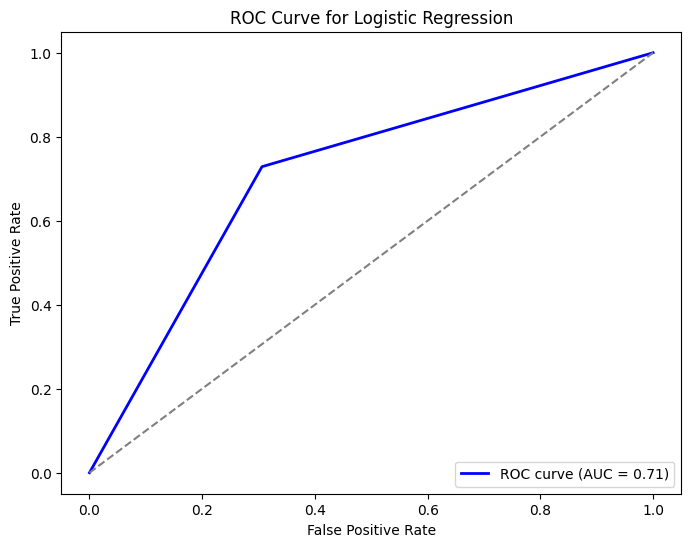

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix


industry_columns = [col for col in df_merged_cleaned.columns if col.startswith('industry_')]
features = ['week', 'vader_score_avg'] + industry_columns
target ='Price_Change_Label'


X_lin = df_merged_cleaned[features]
y_lin = df_merged_cleaned[target]


X_lin = X_lin.reset_index(drop=True)
y_lin = y_lin.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.14, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_predlog = logmodel.predict(X_test)

mselog = mean_squared_error(y_test, y_predlog)
r2log = r2_score(y_test, y_predlog)

print(classification_report(y_test, y_predlog))
print(confusion_matrix(y_test, y_predlog))


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_predlog)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('false positive ')
plt.ylabel('true positive rate')
plt.title('ROC curve for logistic regression')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.59      0.92      0.72       196
           1       0.80      0.32      0.46       188

    accuracy                           0.63       384
   macro avg       0.70      0.62      0.59       384
weighted avg       0.69      0.63      0.59       384



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize


X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.14, random_state=42)
logreg_model = LogisticRegression()
model_nb = GaussianNB()
model_lr = LinearRegression()  
model_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)

logreg_model.fit(X_train, y_train)
model_nb.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_nn.fit(X_train, y_train)

logreg_probs = logreg_model.predict_proba(X_test)[:, 1] 
nb_probs = model_nb.predict_proba(X_test)[:, 1]  
lr_probs = model_lr.predict(X_test)
nn_probs = model_nn.predict_proba(X_test)[:, 1] 

lr_probs_binary = (lr_probs > 0.5).astype(int)

logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_binary)  
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
nb_roc_auc = auc(nb_fpr, nb_tpr)
lr_roc_auc = auc(lr_fpr, lr_tpr)
nn_roc_auc = auc(nn_fpr, nn_tpr)

plt.figure(figsize=(10, 8))
plt.plot(logreg_fpr, logreg_tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {logreg_roc_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, color='green', lw=2, label=f'Naive Bayes (AUC = {nb_roc_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, color='red', lw=2, label=f'Linear Regression (AUC = {lr_roc_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, color='purple', lw=2, label=f'MLP Classifier (AUC = {nn_roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.title('ROC Curves for Naive Bayes, Logistic Regression, Linear Regression, MLP Classifier')
plt.xlabel('false positive')
plt.ylabel('true positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

NameError: name 'X_lin' is not defined

In [ ]:
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
model_nn.fit(X_train, y_train)

y_pred_nn = model_nn.predict(X_test)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       196
           1       0.93      0.91      0.92       188

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384



              precision    recall  f1-score   support

           0       0.99      1.00      0.99       196
           1       1.00      0.99      0.99       188

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384

                  Feature  Importance
1         vader_score_avg    0.451234
0                    week    0.316322
6          industry_Chips    0.023722
19          industry_Soda    0.023511
8          industry_Comps    0.022733
11           industry_Fin    0.020148
5          industry_BusSv    0.018763
3          industry_Autos    0.016792
17         industry_Rtail    0.016440
22  industry_Unclassified    0.013010
12           industry_Fun    0.012822
16           industry_Oil    0.011724
4          industry_Banks    0.009305
15         industry_MedEq    0.009149
7          industry_Clths    0.008179
21         industry_Trans    0.006278
13         industry_LabEq  

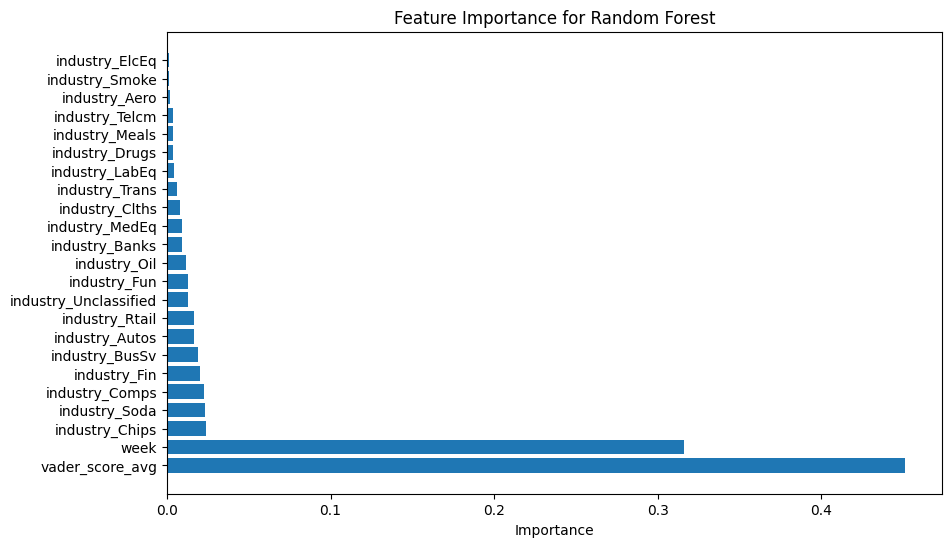

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
importances = model_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_lin.columns,
    'Importance': importances
})

y_pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Random Forest')
plt.show()

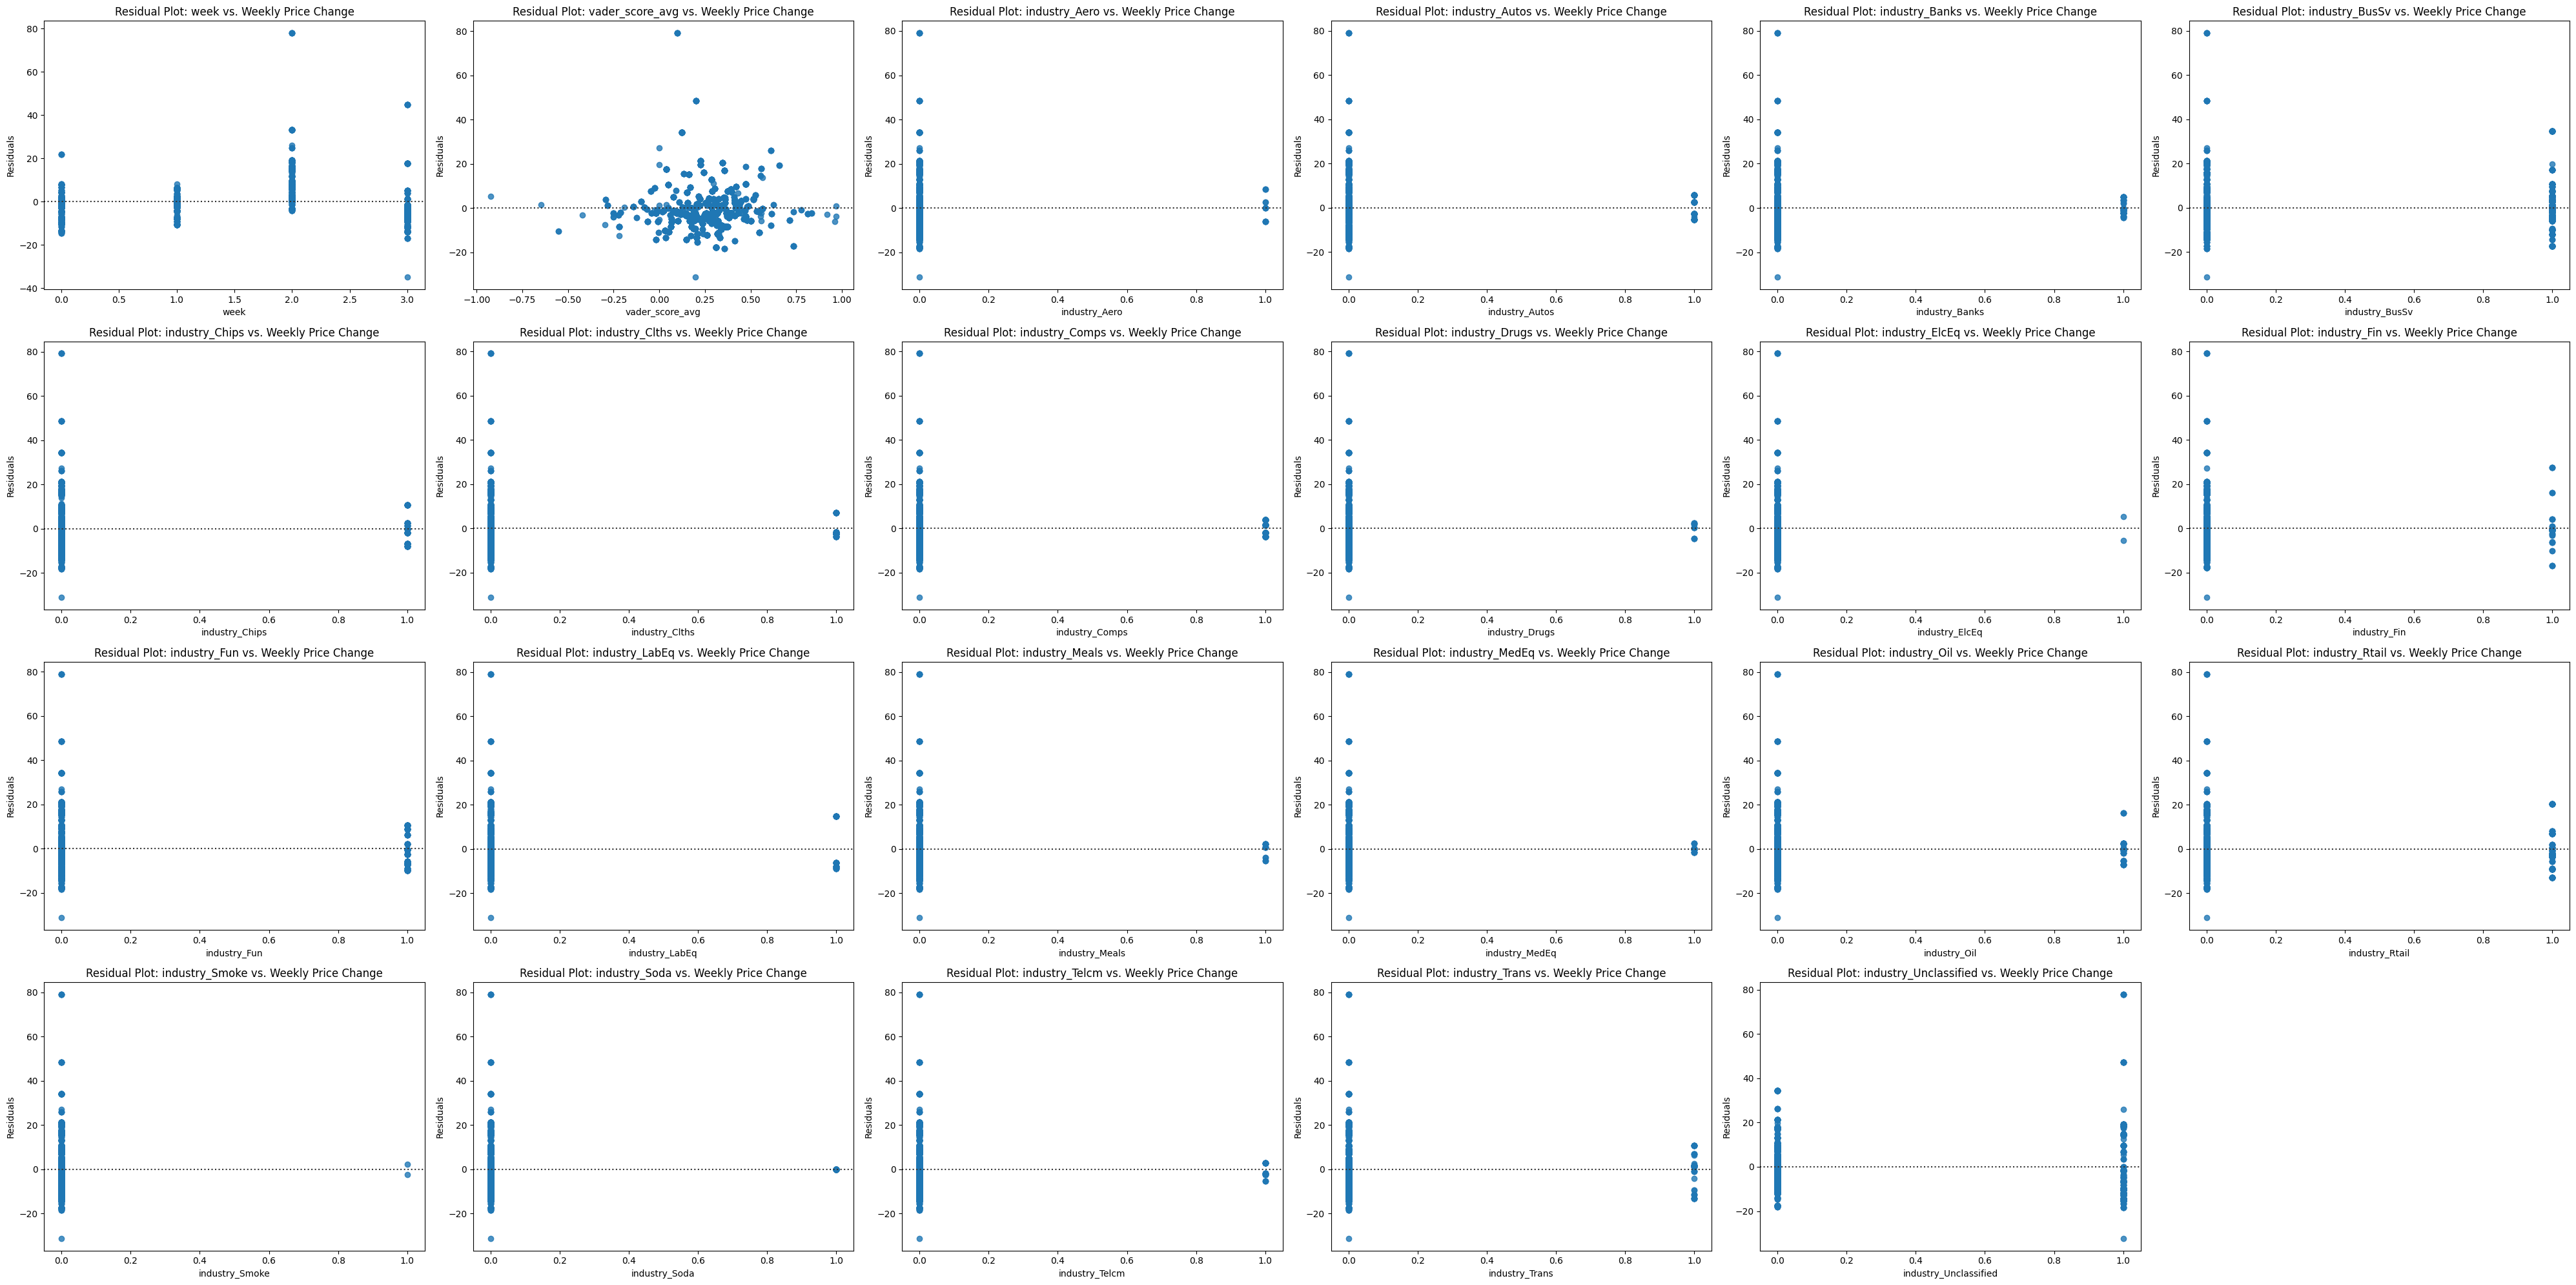

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import math 
num_plots = len(features)
num_cols = 6 
num_rows = math.ceil(num_plots / num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, num_rows * 5))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.residplot(x=feature, y='weekly_price_change', data=df_merged_cleaned, line_kws={'color': 'red'}, ax=axes[i])
    axes[i].set_title(f'Residual Plot: {feature} vs. Weekly Price Change')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Residuals')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Min and Max of y_test: 0, 1
Min and Max of y_pred: -0.19296388827576916, 1.1400777772855792


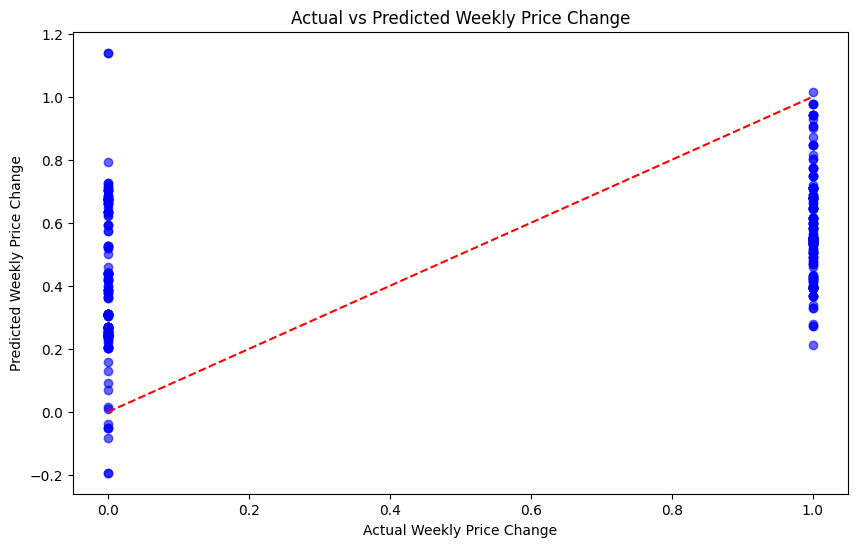

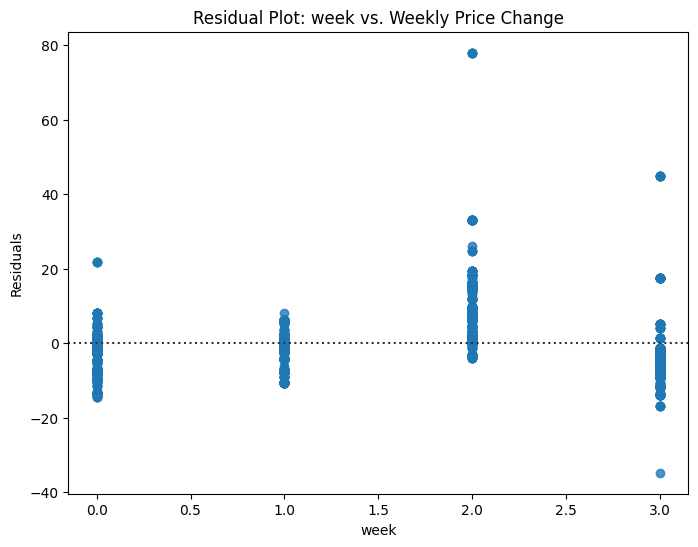

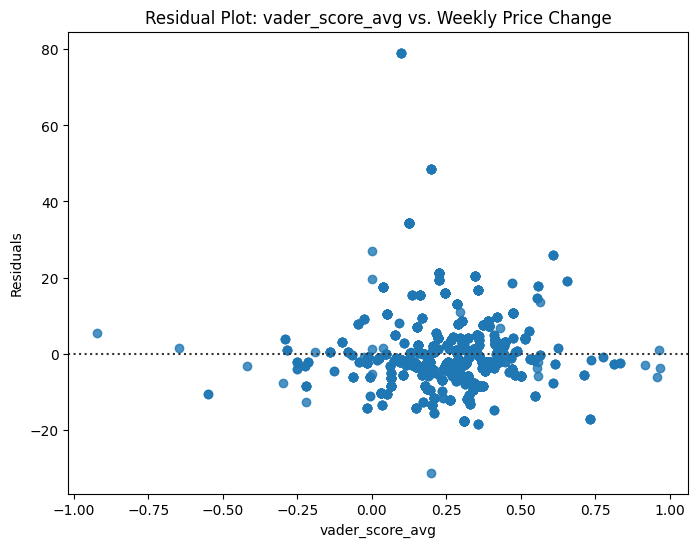

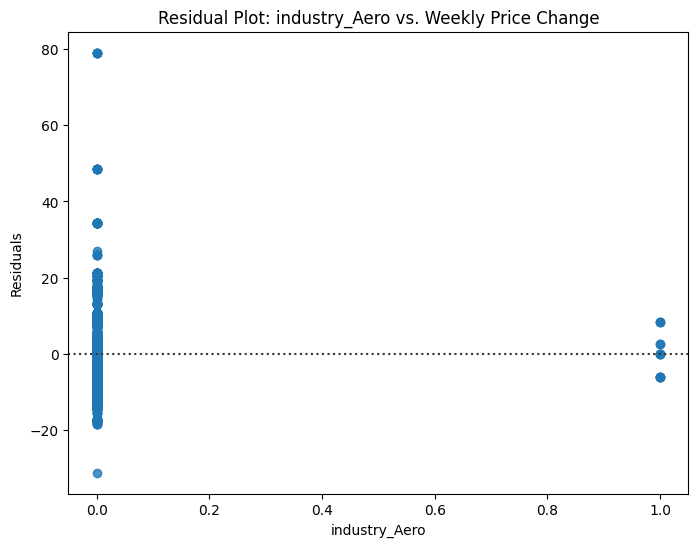

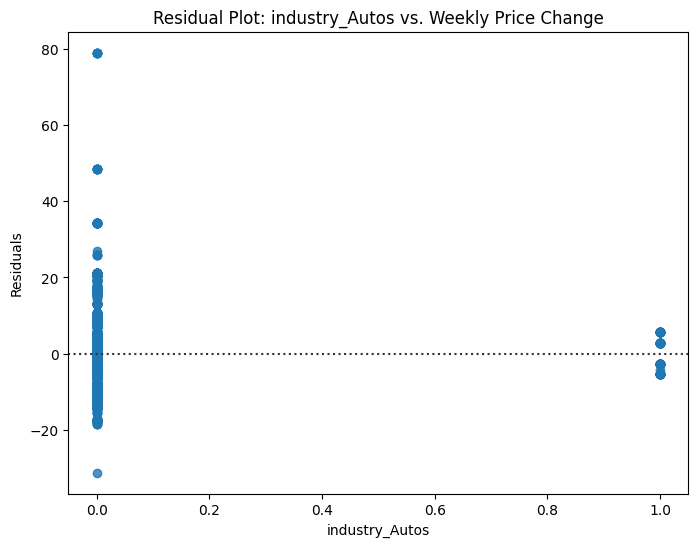

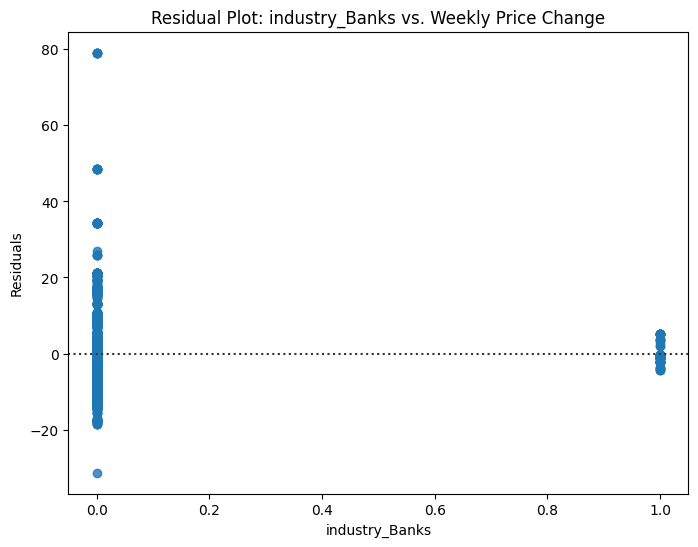

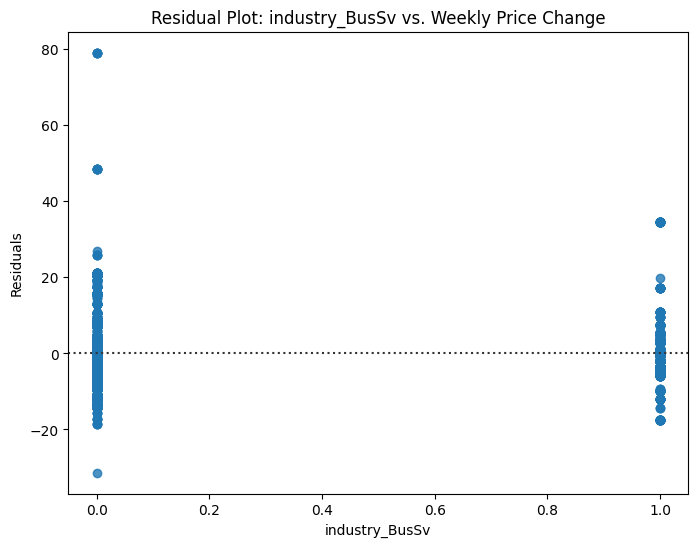

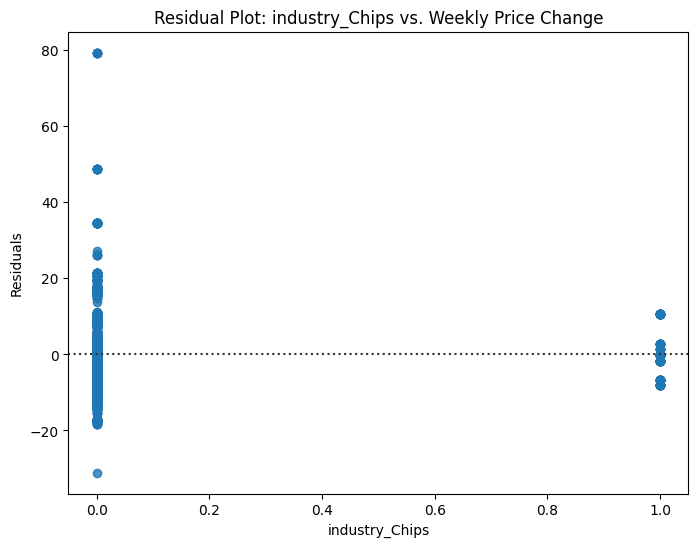

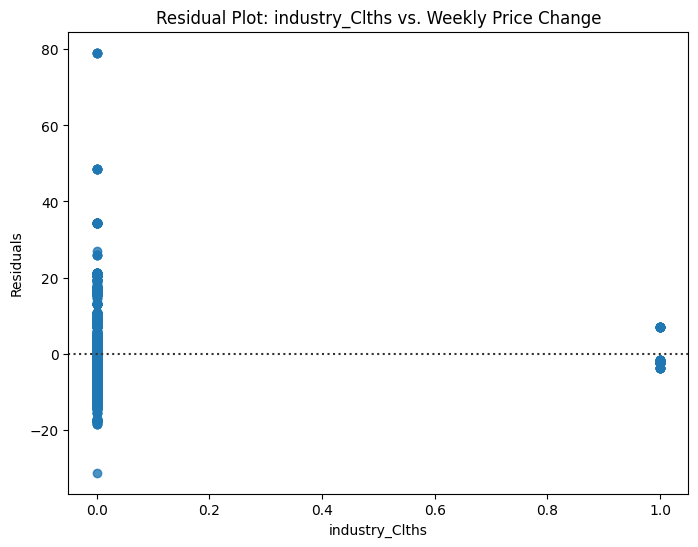

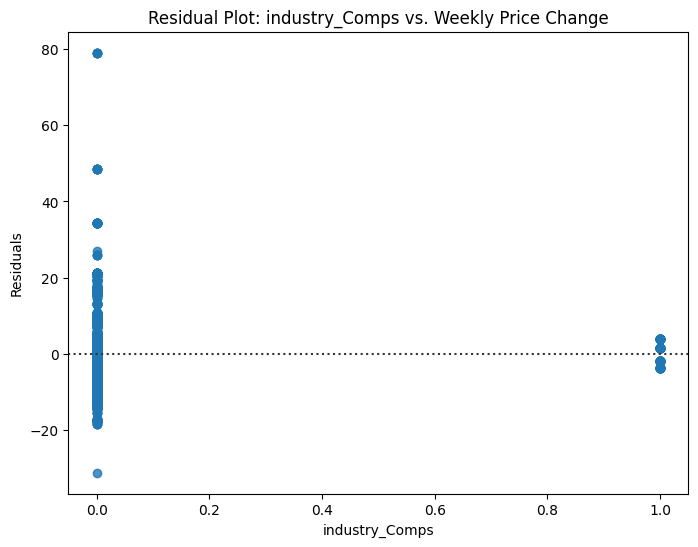

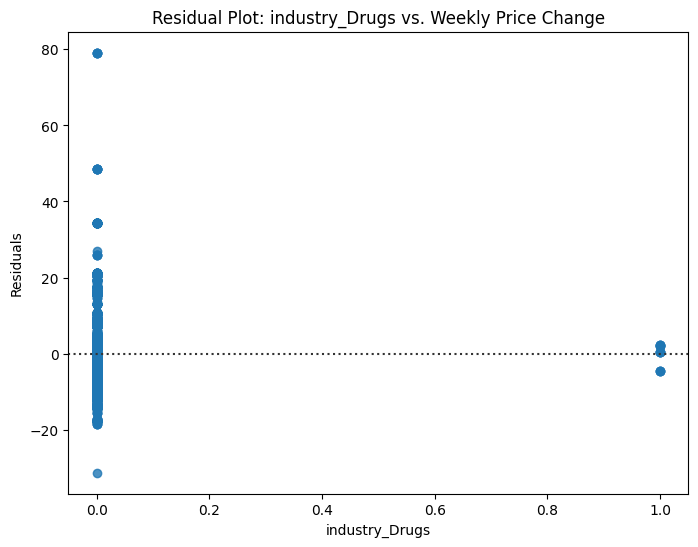

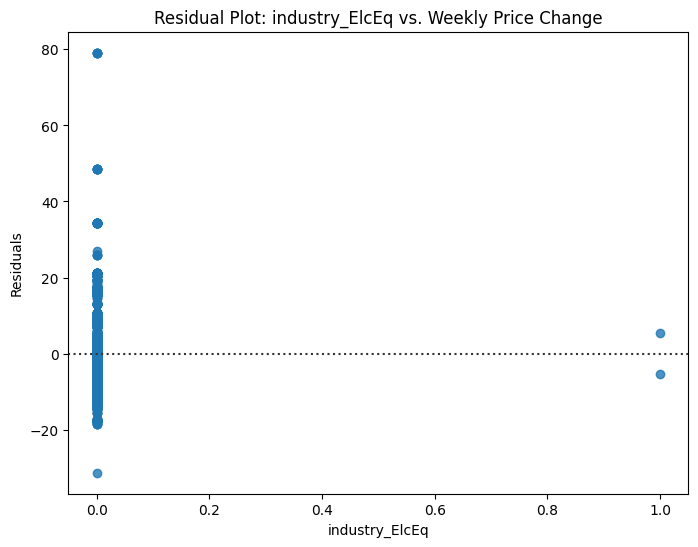

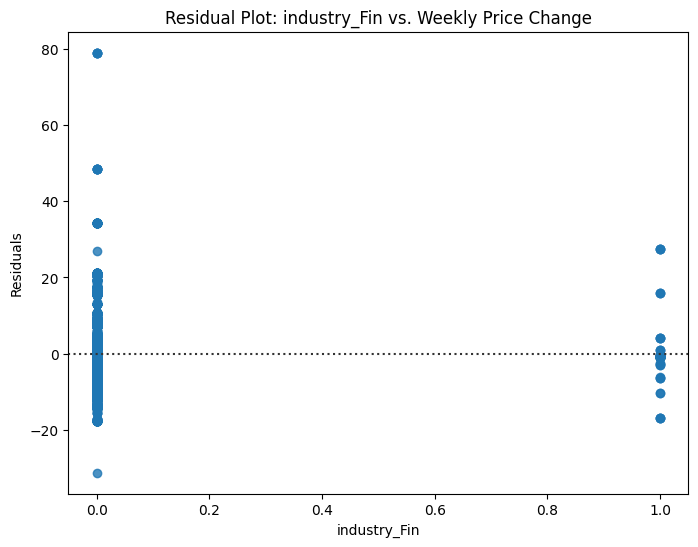

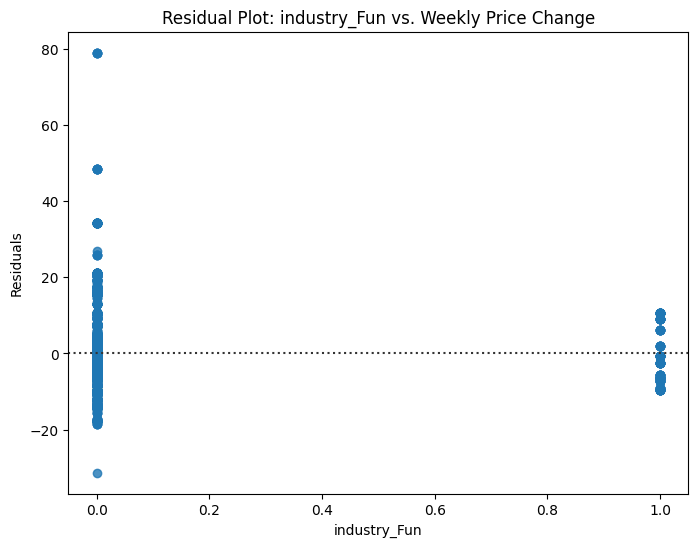

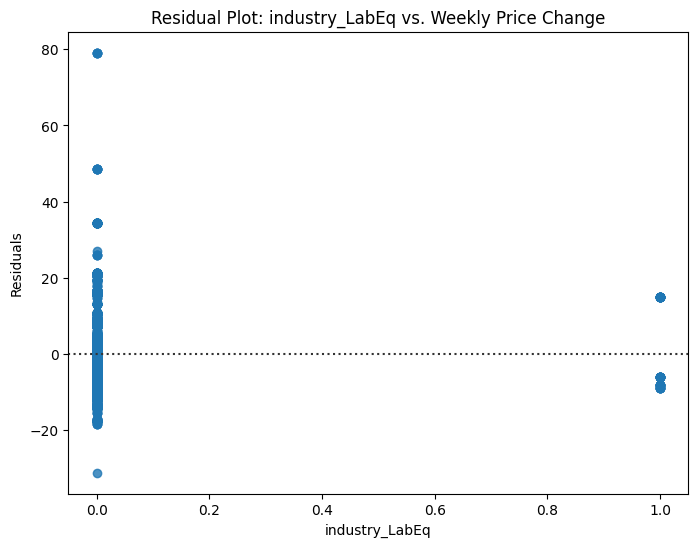

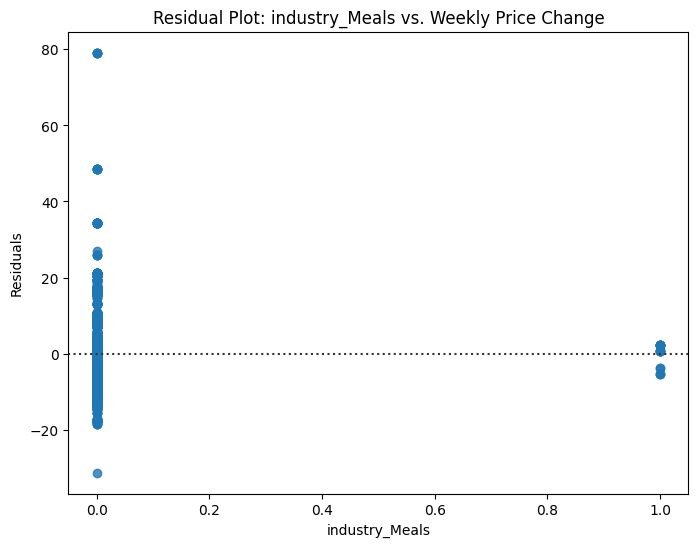

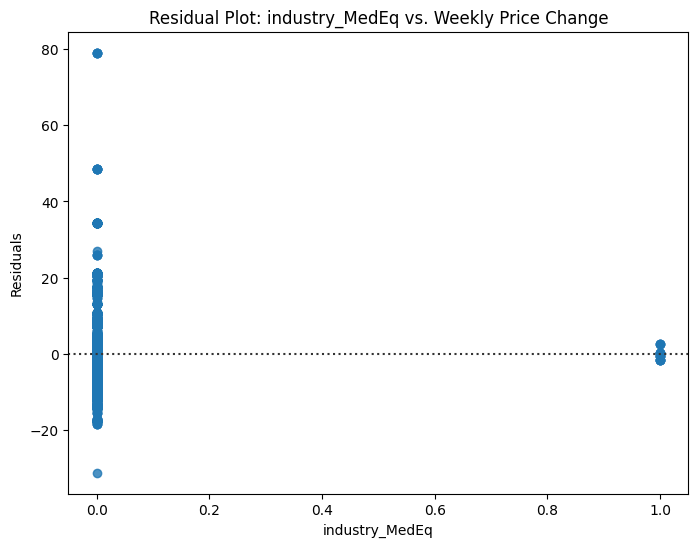

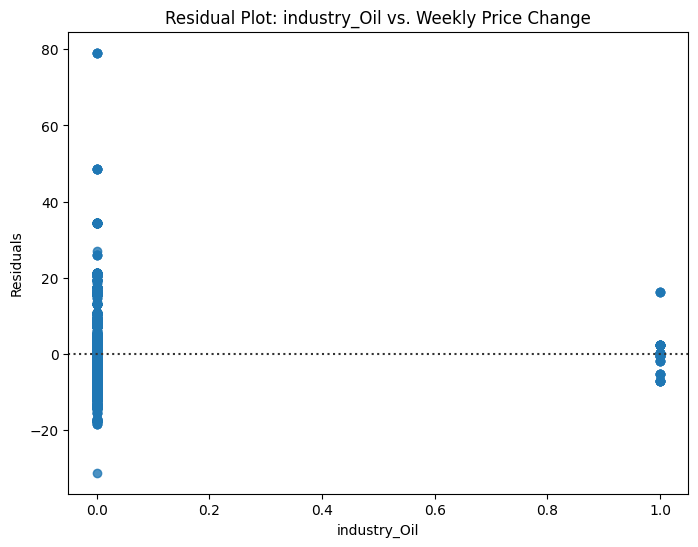

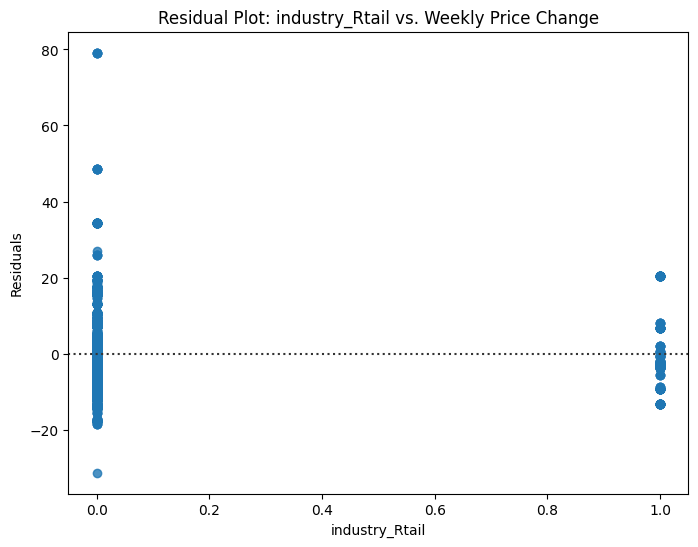

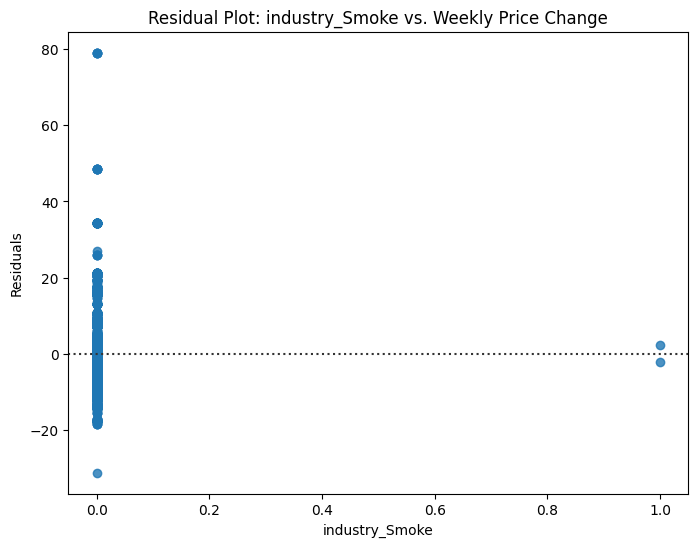

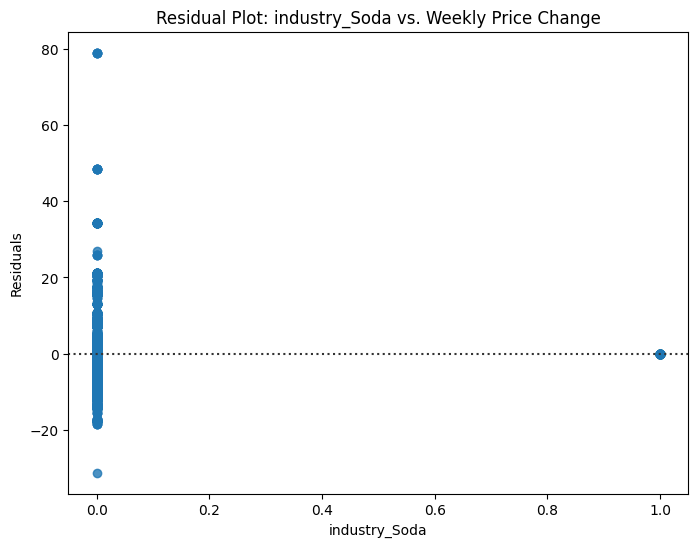

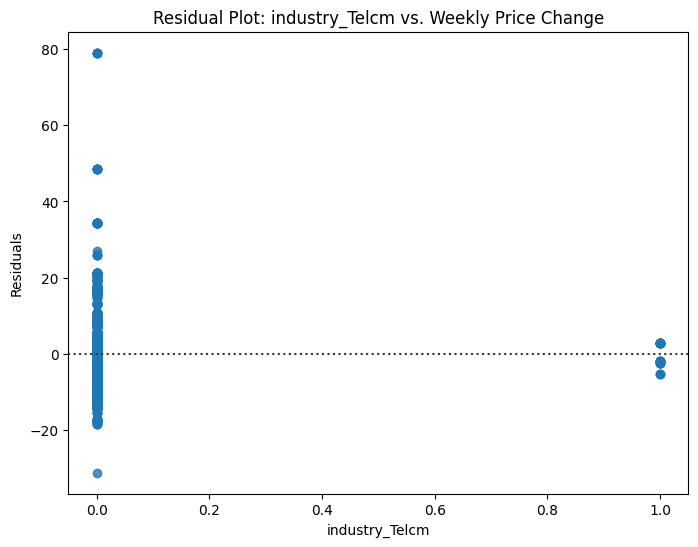

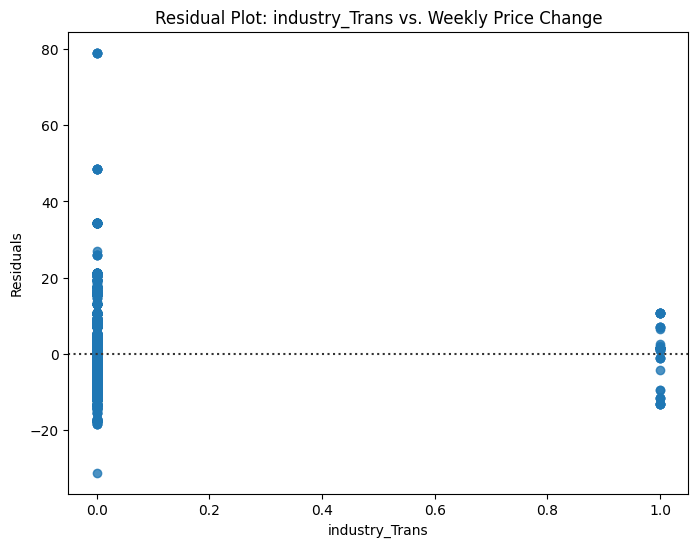

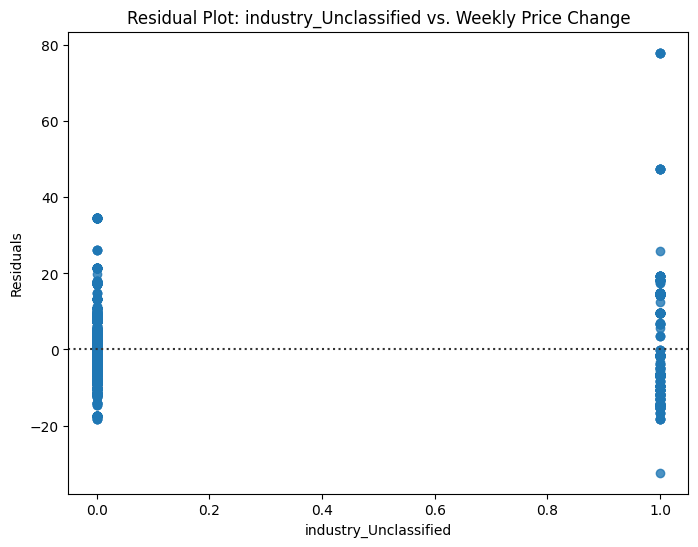

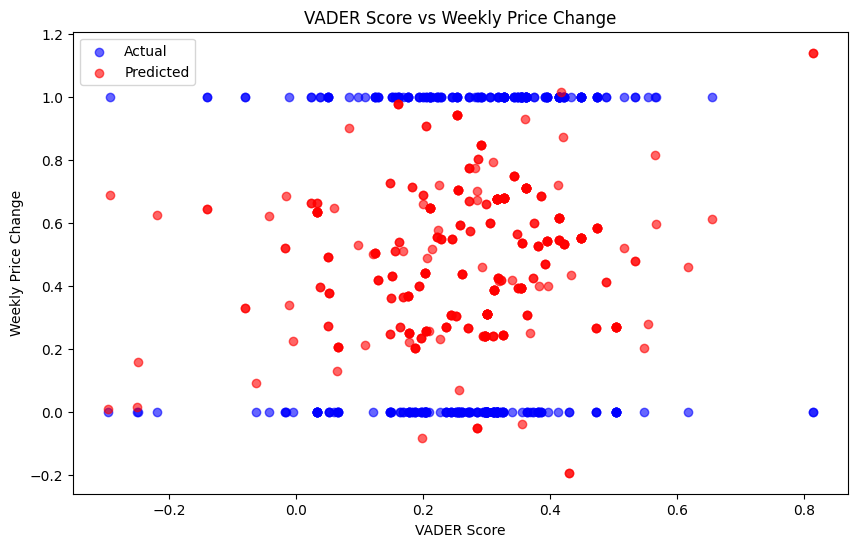

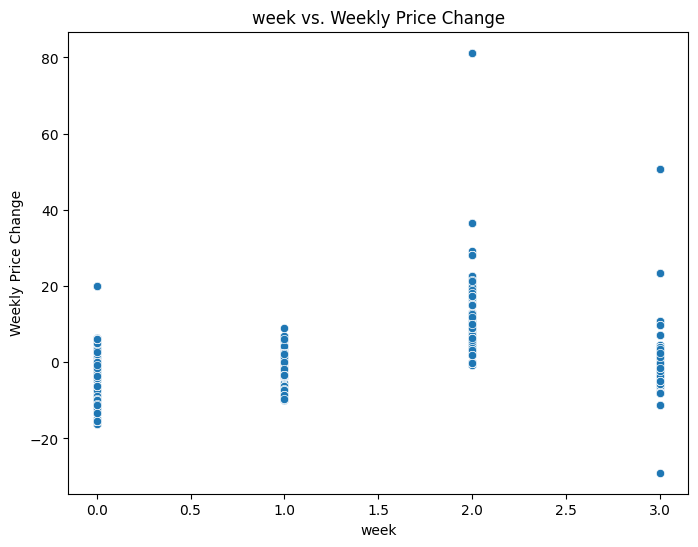

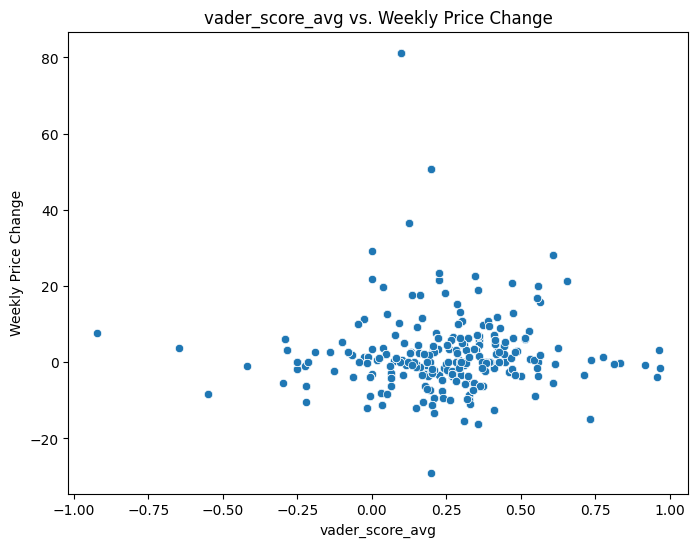

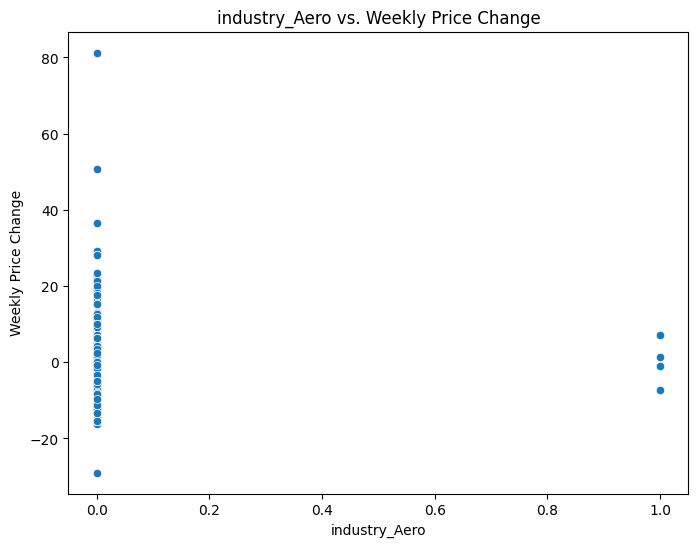

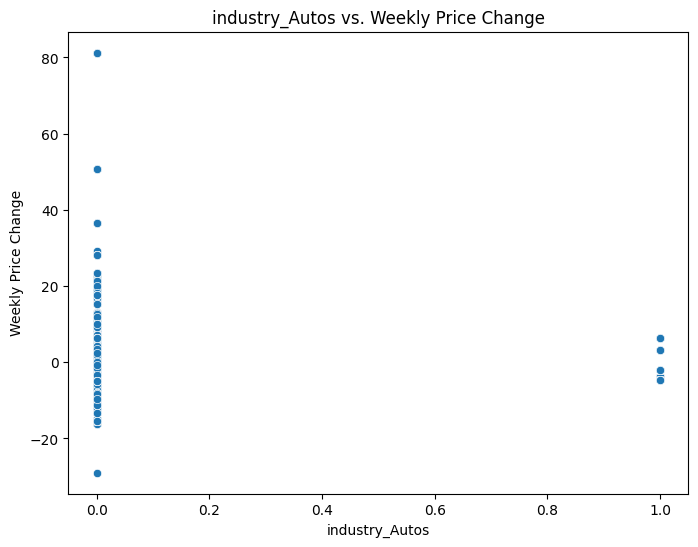

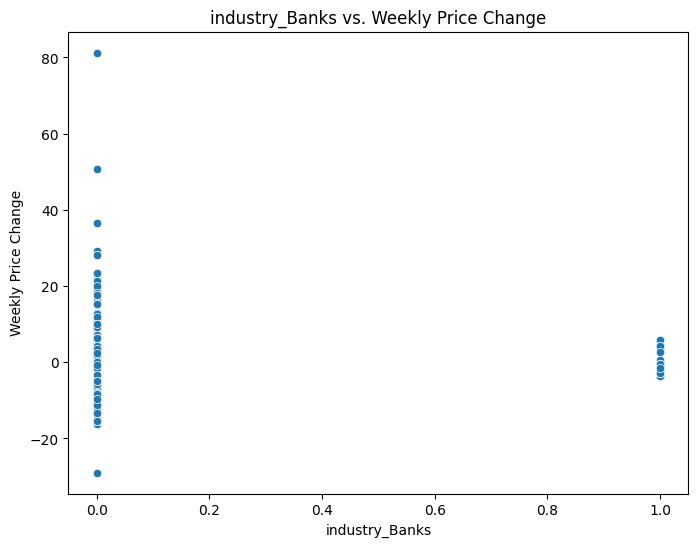

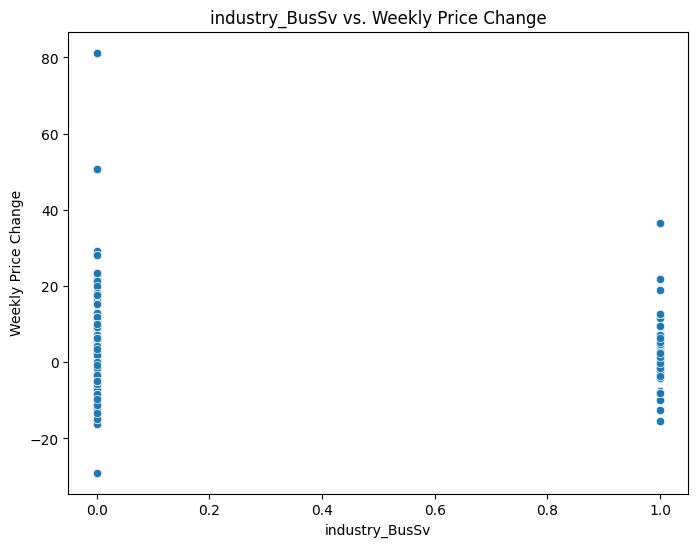

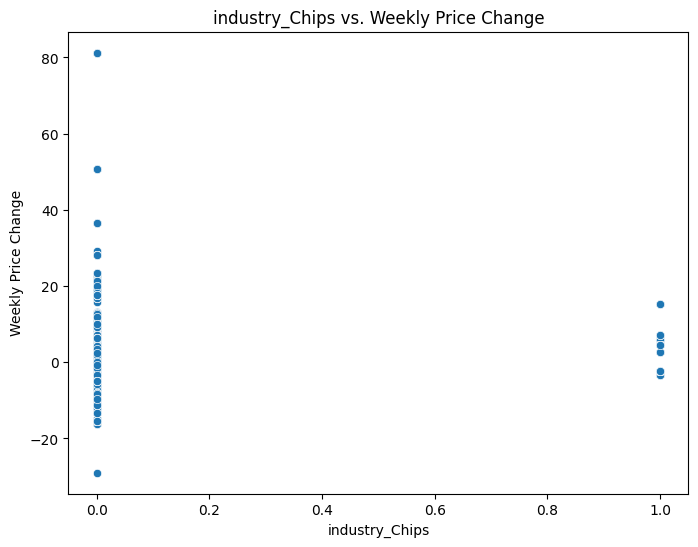

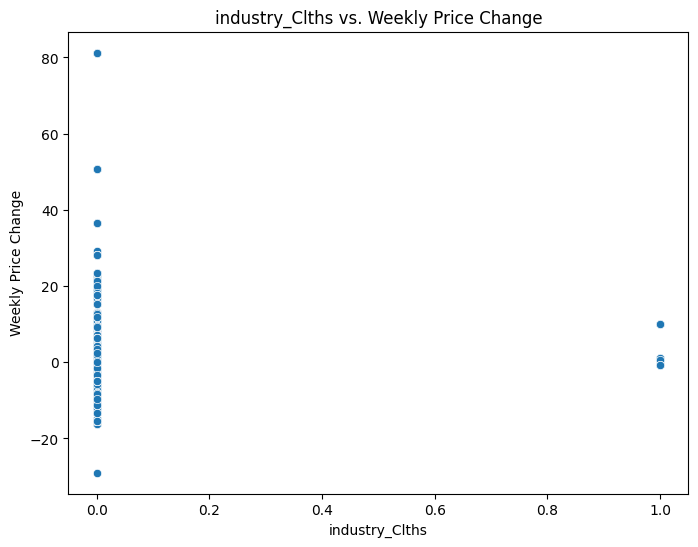

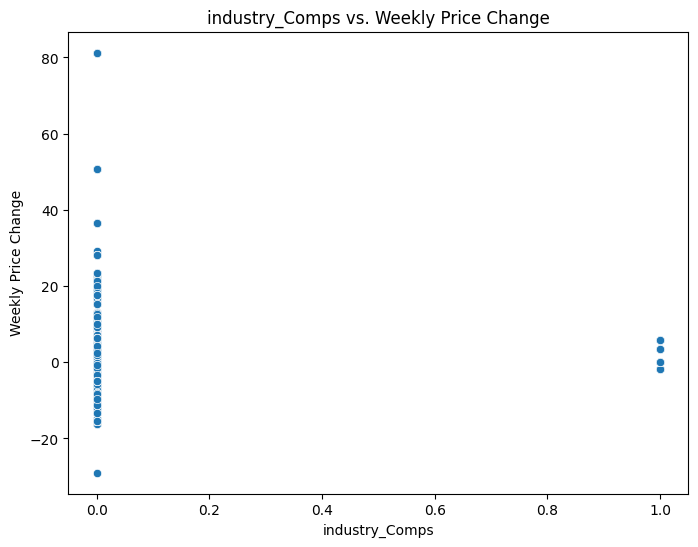

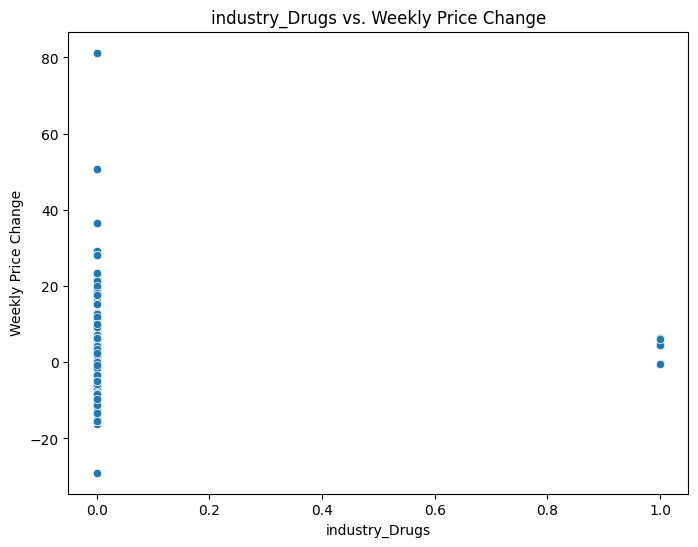

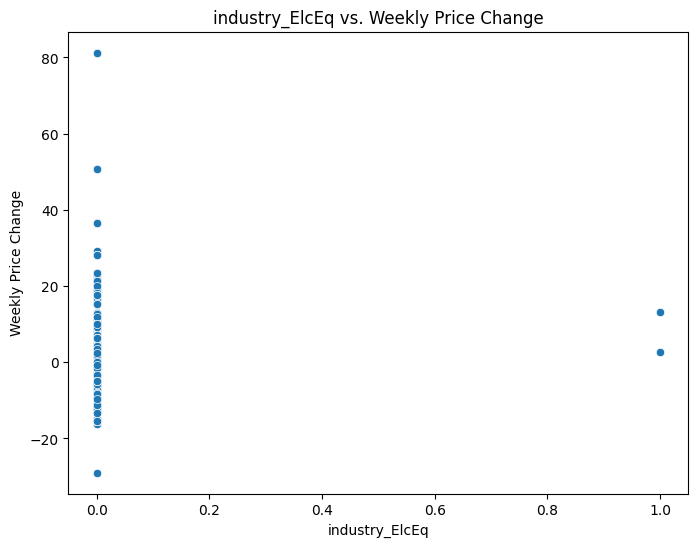

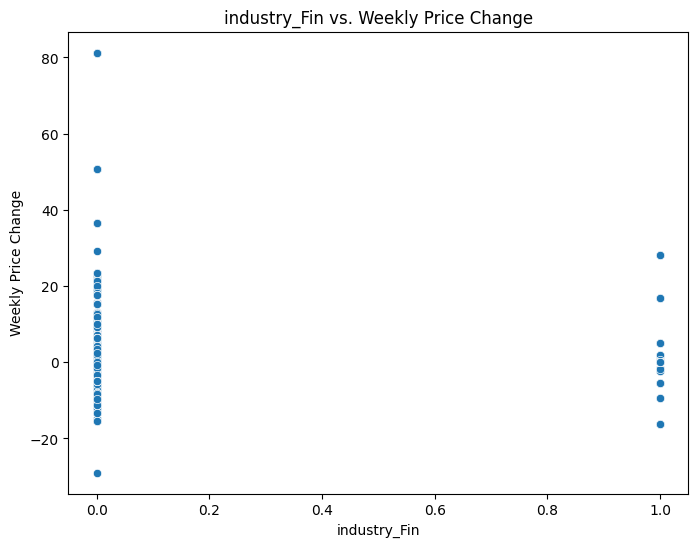

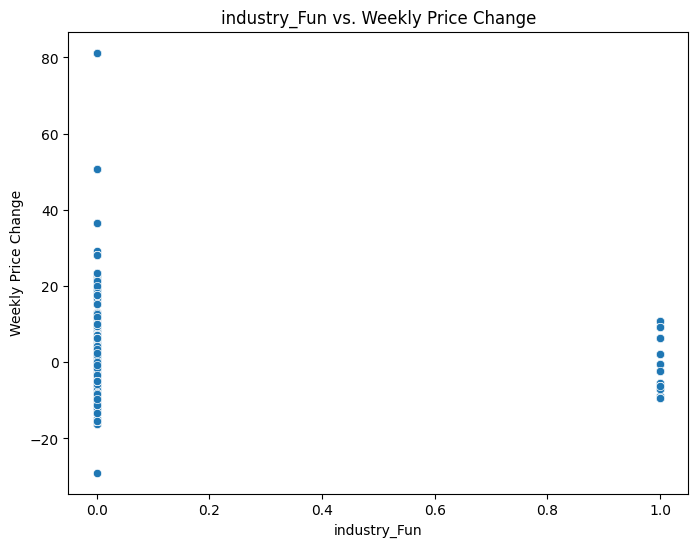

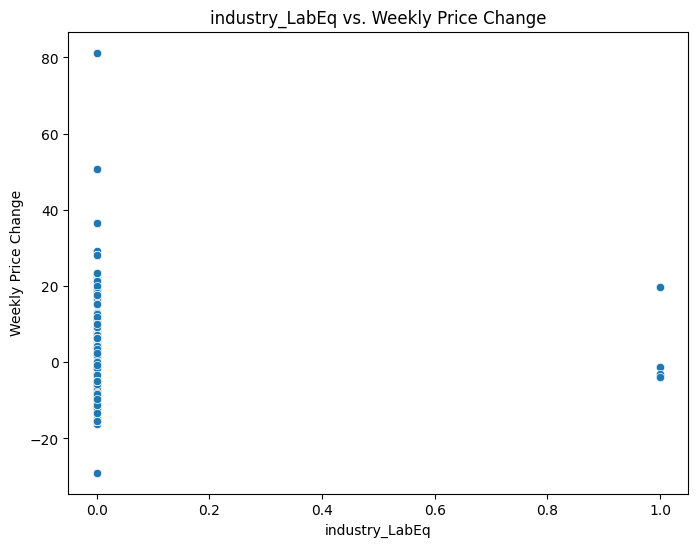

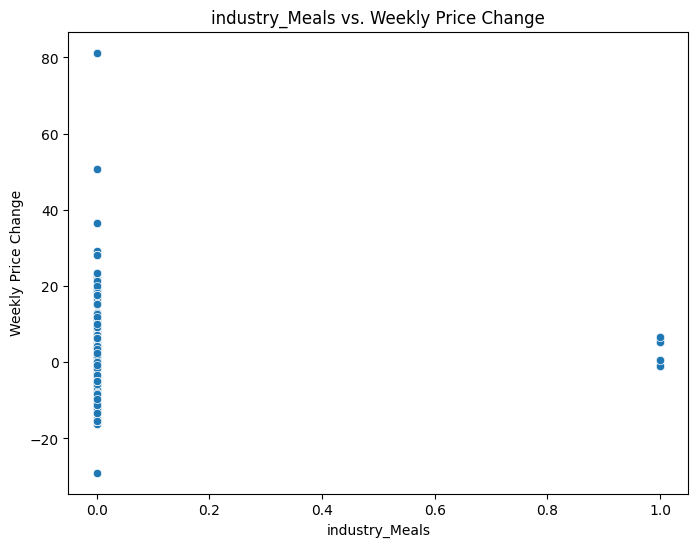

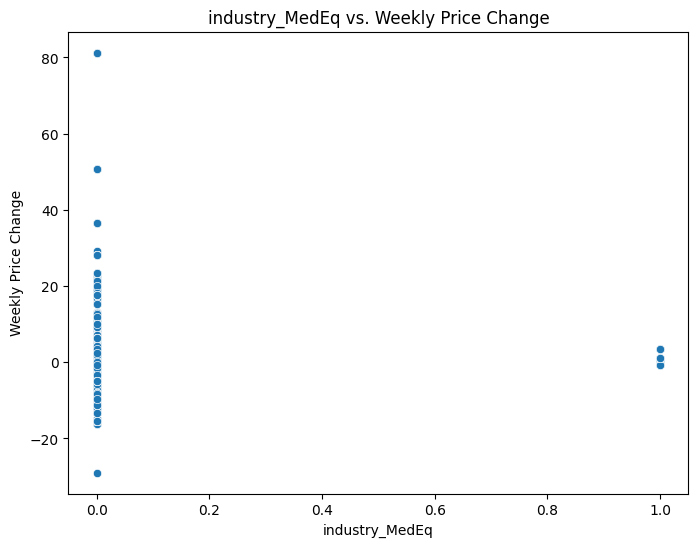

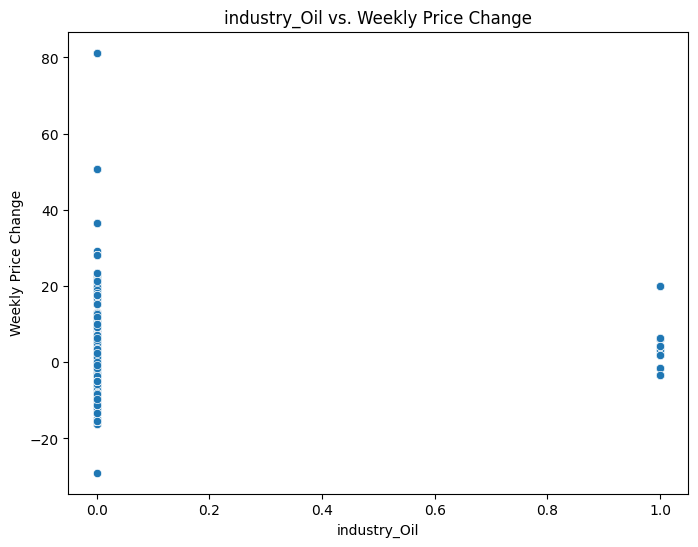

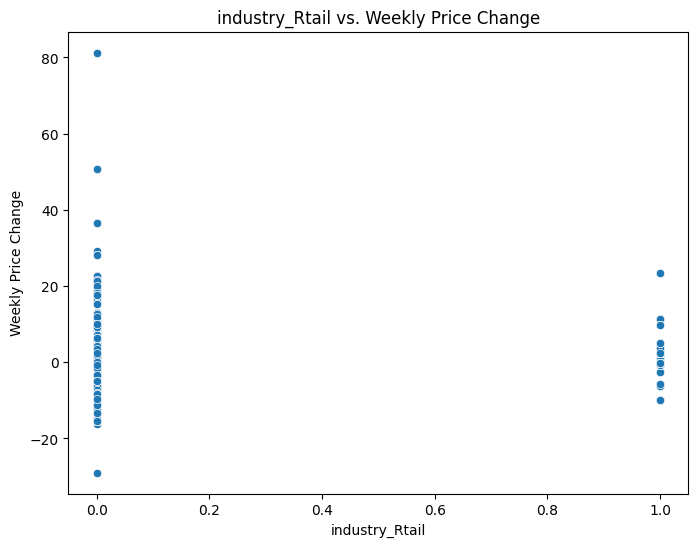

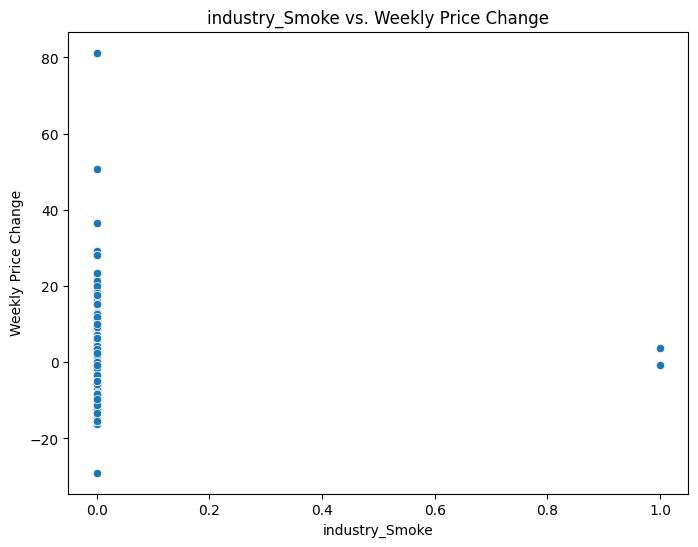

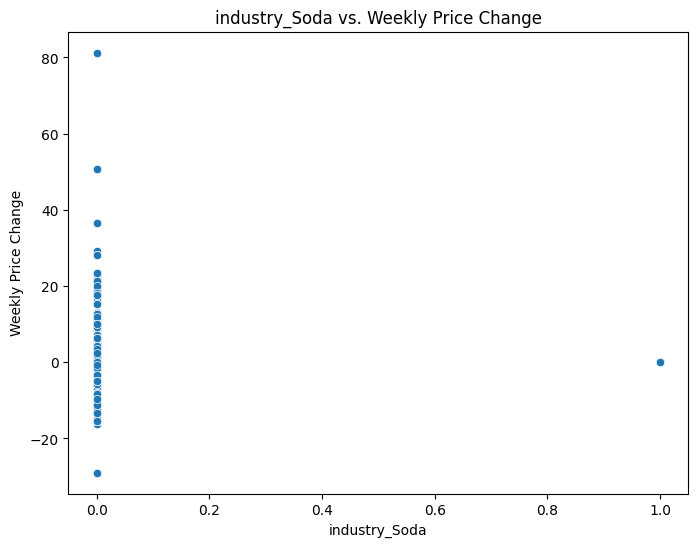

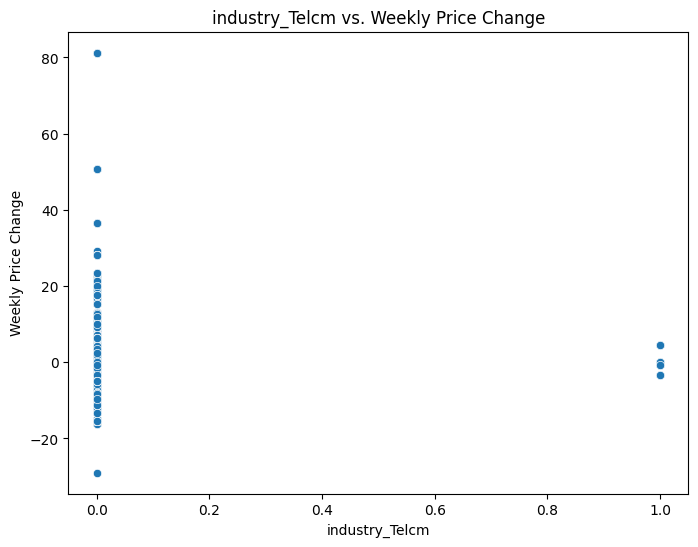

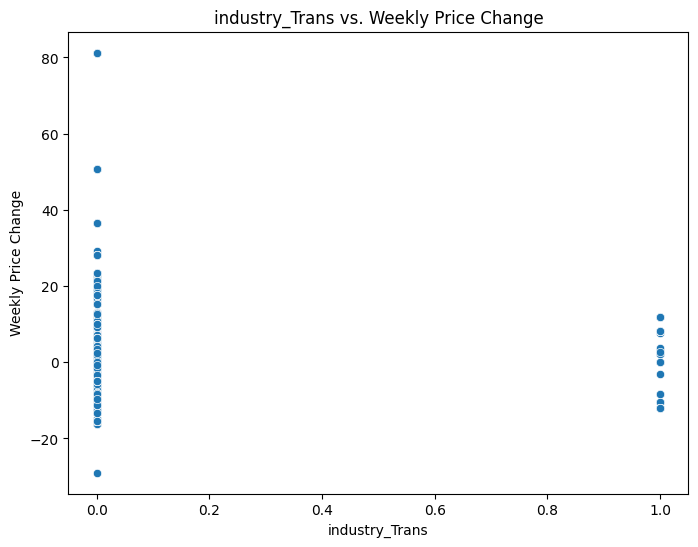

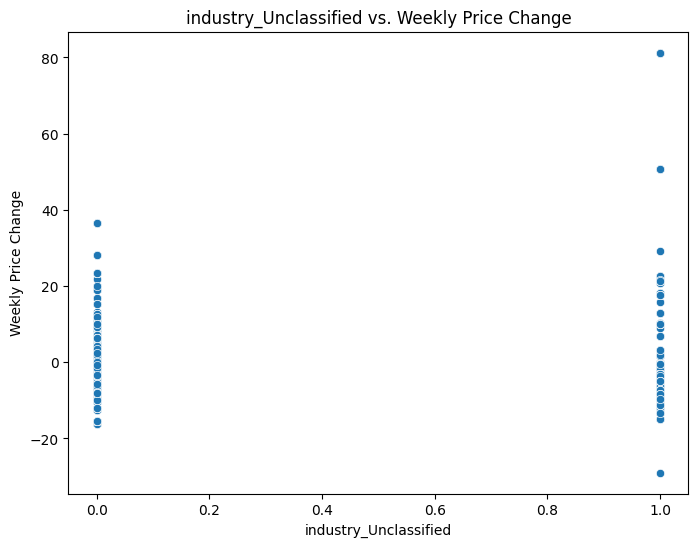

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"min and max of y_test: {y_test.min()}, {y_test.max()}")
print(f"min and max of y pred: {y_pred.min()}, {y_pred.max()}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('actual vs predicted weekly')
plt.xlabel('weekly prediction')
plt.ylabel('predicted weekly change')
plt.show()
